In [2]:
#filesystem operations
import subprocess, glob, os, shutil, datetime, re
import pandas as pd
from dateutil import parser
import seaborn as sns


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly

In order for this to work properly, you should enter path to your working folder

In [4]:
path_to_your_folder=r'C:\My_Sites\qsh2020'

These two folers are needed to download qsh files and convert them to txt format

In [ ]:
#path to the folder where your qsh files are gonna be stored
main_folder=r'C:\My_Sites\qsh2020\erinrv.qscalp.ru'
#path to the folder where your converted to txt files are gonna be stored
target_folder=r'C:\My_Sites\qsh2020\txt_version'

# Part 1: Work with files
 At first, we need to convert batch of files from qsh to txt. There is an util here: https://www.qscalp.ru/download for this purpose. However, we also need to save converted files in a distinct folder.

In [1]:
path_to_converting_util=r''

Since there is a lot of data at http://erinrv.qscalp.ru/, the following code snippet may be useful. It extracts links from website and writes it in a new tab:


var x = document.querySelectorAll("a");
var myarray = []
for (var i=0; i<x.length; i++){
var nametext = x[i].textContent;
var cleantext = nametext.replace(/\s+/g, ' ').trim();
var cleanlink = x[i].href;
myarray.push([cleantext,cleanlink]);
};
function make_table() {
    var table = '<table><thead><th>Name</th><th>Links</th></thead><tbody>';
   for (var i=0; i<myarray.length; i++) {
            table += '<tr><td>'+myarray[i][1]+'</td></tr>';
    };
 
    var w = window.open("");
w.document.write(table); 
}
make_table()
                                   


At first, we need to convert batch of files from qsh to txt. There is an util here: https://www.qscalp.ru/downloadThen for this purpose. However, we also need to save converted files in a distinct folder.

In [ ]:
def convert_all(path, path_to_converting_util):
    #convert qsh files to txt
    os.chdir(path)
    files=os.listdir(path=".")
    print('list of qsh files:', files)
    for file in files:
        subprocess.run([path_to_converting_util, file])
        print(file, 'converted')
        
        
def move_all_txts(source_dir):
    #make directory named 'copies'
    
    directory = "copies"
    new_dir_path = os.path.join(source_dir, directory) 
    try:
        os.mkdir(new_dir_path) 
    except OSError:
        # The directory already existed, nothing to do
        pass
    files = glob.iglob(os.path.join(source_dir, "*.txt"))
    for txt_file in files:
        shutil.move(txt_file, new_dir_path)



The function below is used to convert files to txt and save them in a separate folder

In [ ]:
def is_stonks(path):
    somestring=path.split('\\')[-1]
    if re.match(r'^[A-Z][A-Z][A-Z][A-Z]', somestring):
        return True
    else:
        return False

    
def convert_and_move(source_folder,dest_folder, path_to_converting_util):
    
    '''this function takes all .qsh files from the source folder, except for those who do not begin with 4 letters.
    Then it converts them to .txt format with given converter.
    Then it cuts and pastes them to destination folder'''
    
    os.chdir(source_folder)
    files=os.listdir(path=".")
    #print('list of qsh files:', files)
    for file in files:
        if is_stonks(file):
            subprocess.run([path_to_converting_util, file])
        #print(file, 'converted')
    files = glob.iglob(os.path.join(source_folder, "*.txt"))
    for txt_file in files:
        shutil.move(txt_file, dest_folder)
    


This code converts whole stock data folder into similar folder with stock data in .txt format. All the files containing non-stocks data is ignored.

In [ ]:
main_folder=r'C:\My_Sites\qsh2020\erinrv.qscalp.ru'
target_folder=r'C:\My_Sites\qsh2020\txt_version'
for folder in os.listdir(main_folder):
#     print(folder+'!!!')
#     print(os.path.join(main_folder,folder))
    target=os.path.join(target_folder,folder)
    try:
        os.mkdir(target) 
    except OSError:
        print('Despite it should not, the folder '+folder+'somehow managed to exist before you tried to create it! Be cautious!!!')
    convert_and_move(os.path.join(main_folder,folder),target, path_to_converting_util)

# Part 2: Bid-ask spread
In this part I extract bid-ask spread characteristics during daytime. Since I chose to extract mean values during daytime, this may be not representative enough. In addition, work with missing values and 'Unknown' values needs to be done.

But at first, we should set paths to everything:

In [9]:
#windows version:

# main_folder=r'C:\My_Sites\qsh2020\txt_version'
# buffer=r'C:\My_Sites\qsh2020\buffer\buffer.txt'
# where_to_append_result=r'C:\My_Sites\qsh2020\bid_ask.csv'

#linux version:
main_folder=r'/run/media/pchome/21F9F94B20E94FA0/My_Sites/qsh2020/txt_version'
buffer=r'/run/media/pchome/21F9F94B20E94FA0/My_Sites/qsh2020/buffer/buffer.txt'
where_to_append_result=r'/run/media/pchome/21F9F94B20E94FA0/My_Sites/qsh2020/bid_ask.csv'

In [ ]:
def extract_spread_from_txt_shares_file(file, buffer, where_to_append_result):
    '''At first, we transform raw txt file to a csv-readable form. 
    Then we extract mean relative spread from the file.
    Then we append extracted spread to a new file containing our extracted features.
    Then we delete buffer file.'''
    
    
    # this part extracts best bids+best asks+time into a buffer file
    with open(file, "r") as f:
        rows = f.readlines()
        with open(buffer, "w") as dest:
            cur_bb=None
            cur_ba=None
            dest.write('BestBid,BestAsk,Time\n')
            for row in rows:
                if 'Received' in row:
                    current_time=(parser.parse(row.split(' ')[-1])+datetime.timedelta(hours=10)).time()
                    if not cur_bb:
                        cur_bb="NA,"
                    if not cur_ba:
                        cur_ba="NA,"
                    # we choose to observe only day trade:
                    if current_time>=parser.parse('10:00:00').time() and current_time<parser.parse('18:40:00').time():
                        dest.write(cur_bb+cur_ba+str(current_time)+'\n')
                    cur_bb=None
                    cur_ba=None
                elif 'BestBid' in row:
                    cur_bb=','.join(row.split(';')[1:2]).rstrip()+','
                elif 'BestAsk' in row:
                    cur_ba=','.join(row.split(';')[1:2]).rstrip()+','

                    
    # here I extract name and date from the filename:
    filename=file.split('\\')[-1]
    name=filename[0:4]
    date=re.findall(r'\d\d\d\d-\d\d-\d\d',filename)[0]
    
    
    # this part extracts mean spread
    
    
    data=pd.read_csv(buffer)
    data['Spread']=data['BestAsk']-data['BestBid']
    data['Rel_spread_percents']=50*(data['BestAsk']-data['BestBid'])/(data['BestAsk']+data['BestBid'])
    # spread_mean=data['Spread'].mean()
    rel_spread_mean=data['Rel_spread_percents'].mean()

    result=pd.DataFrame(np.array([[date, name, rel_spread_mean]])
                        ,columns=['date','name','mean_relative_spread'])
    
    # this part appends result to the given file:
    result.to_csv(where_to_append_result, mode='a',header=False,index=False)
    
    #this part deletes buffer file:
    os.remove(buffer)
    

Now we have to iterate through all quotes txt data. Since this step takes several hours, it should be written more efficiently

In [ ]:
for folder in os.listdir(main_folder):
#     print(folder+'!!!')
#     print(os.path.join(main_folder,folder))
    source=os.path.join(main_folder,folder)
    for filename in os.listdir(source):
        #filename=file.split('\\')[-1]
        if 'Quotes' in filename:
            file=os.path.join(source, filename)
            extract_spread_from_txt_shares_file(file, buffer, where_to_append_result)

### Big picture of mean daytime bid-ask spreads in 2020:
Here I take a median of relative spread amongst all tickers. Since this is a relative value in percents, the median of relative bid-ask spreads for different tickers may be representative.

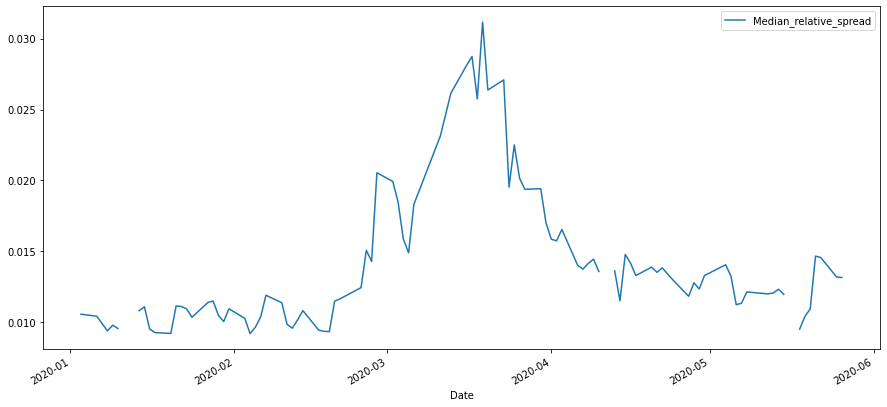

In [358]:
df=pd.read_csv(where_to_append_result, names=['Date','Ticker','Median_relative_spread'])
df['Date']=pd.to_datetime(df['Date'])
df=df.set_index('Date')

plt.figure(figsize=(15,7))
df.groupby('Date')['Median_relative_spread'].median().plot(legend='Relative spread median amongst all stocks')


### Daytime bid-ask spreads for different tickers in 2020:
It may be interesting to look at mean bid-ask spreads for different tickers

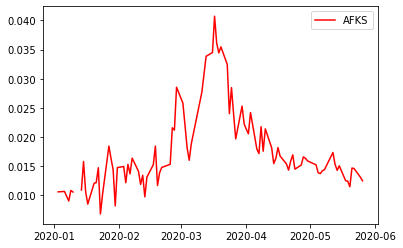

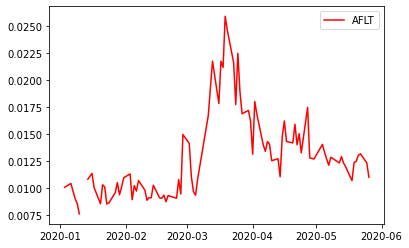

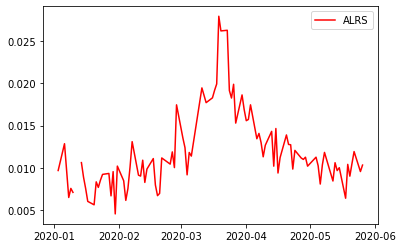

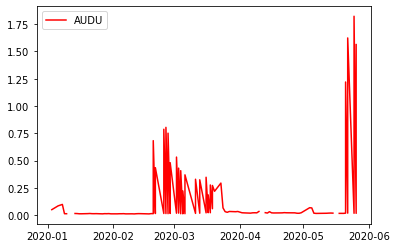

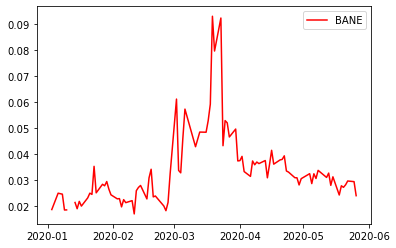

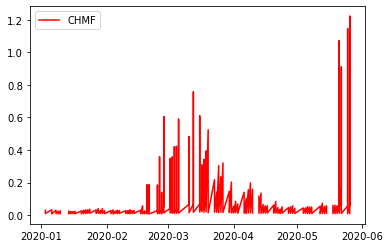

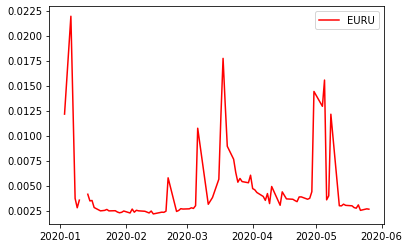

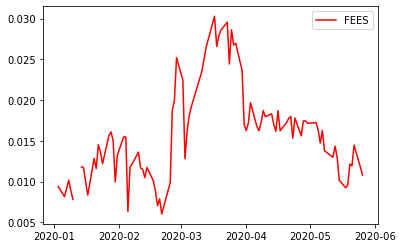

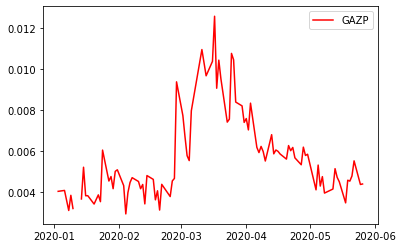

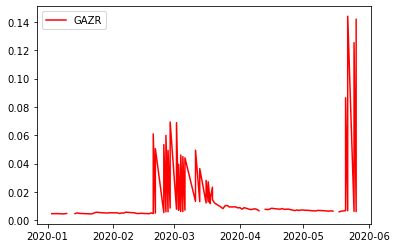

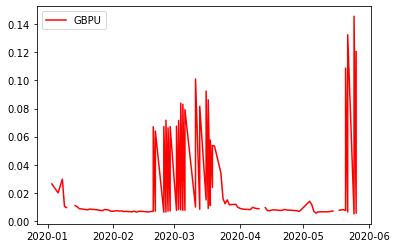

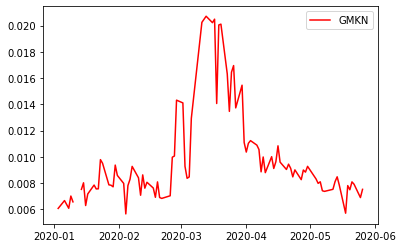

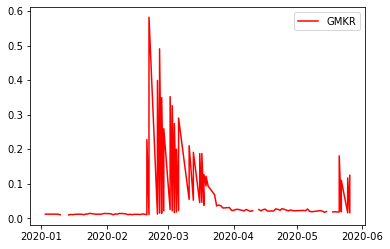

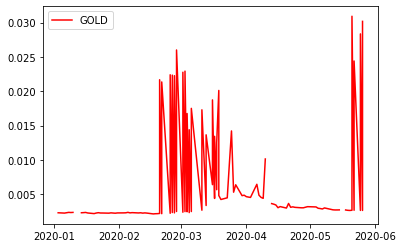

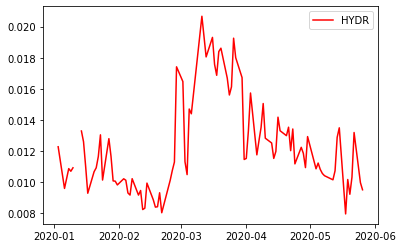

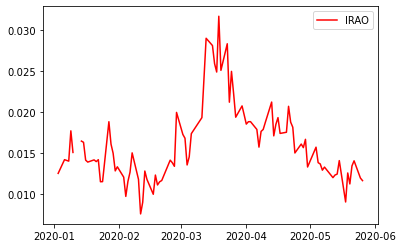

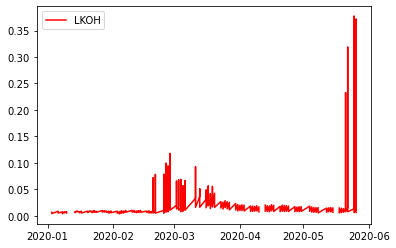

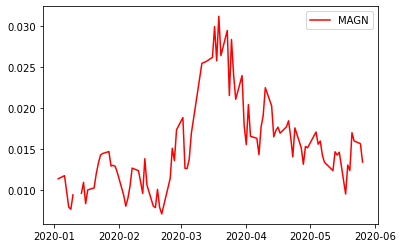

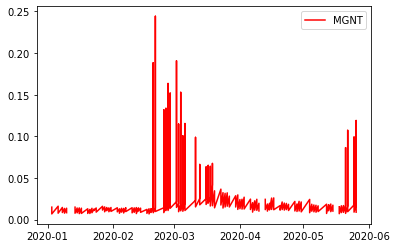

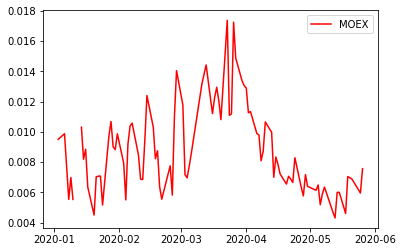

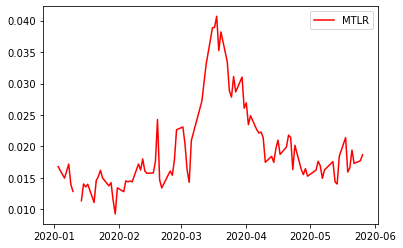

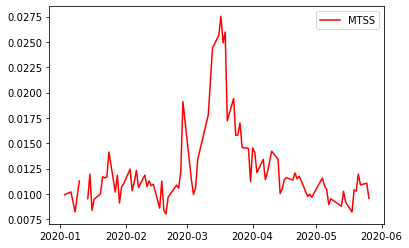

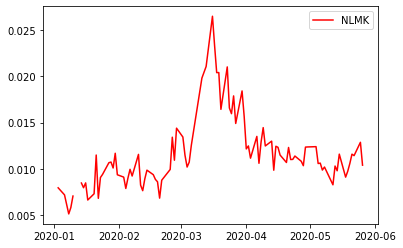

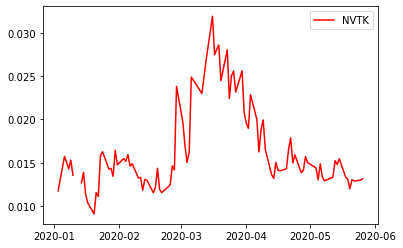

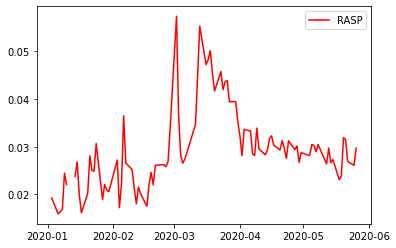

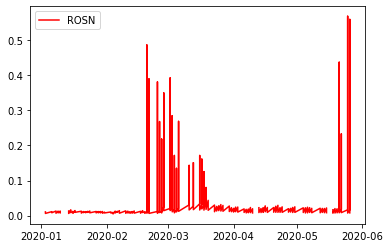

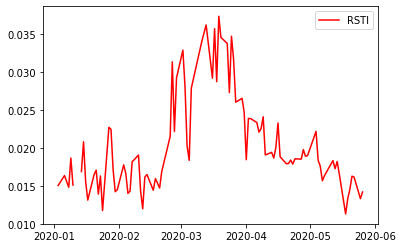

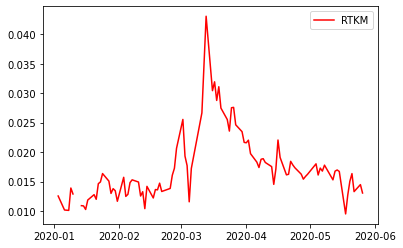

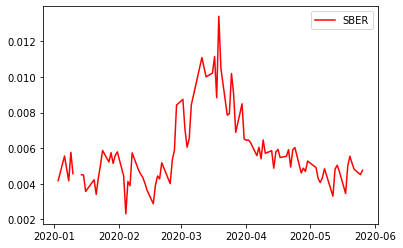

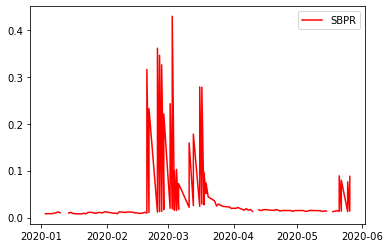

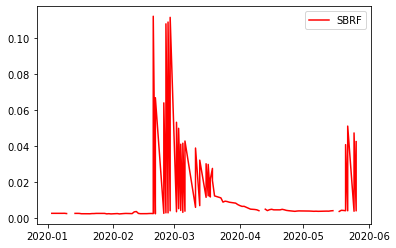

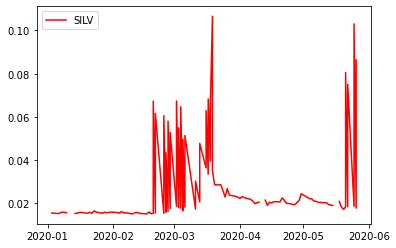

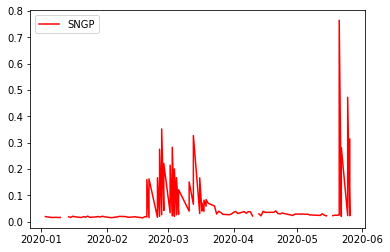

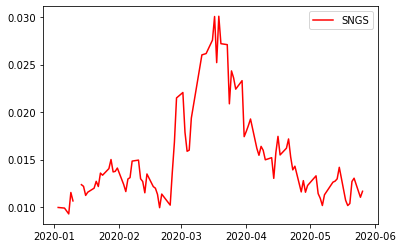

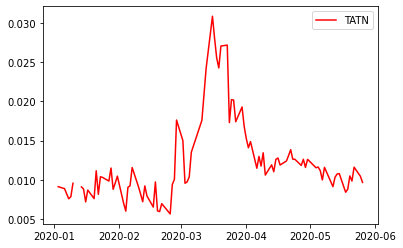

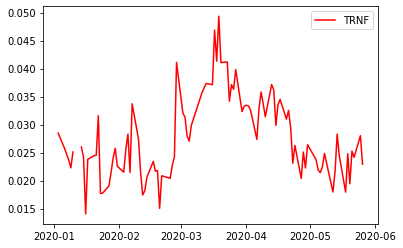

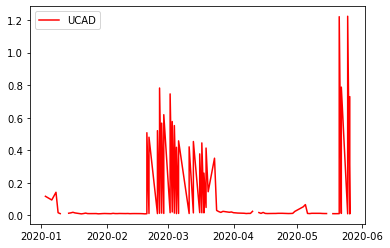

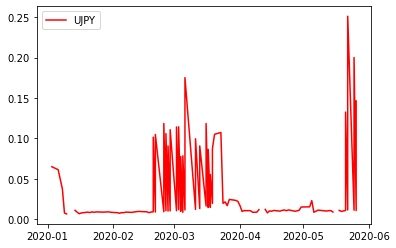

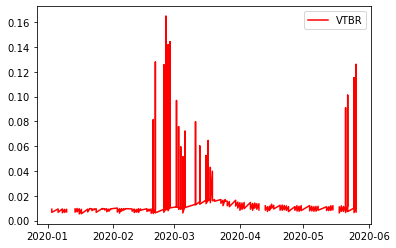

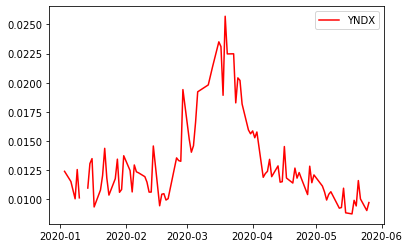

In [11]:
# mean relative spread for distinct stocks over tim

for name in df['Ticker'].unique():
    plt.plot(df[df['Ticker']==name].index, df[df['Ticker']==name]['Mean_relative_spread'],'r')
    plt.legend([name])
    plt.show()
# monthly_mean.plot(x=df.index, y='A')

# Part 3: Volume and turnover
Here I extract daytime trade volume. The turnover rate from this article https://www.imf.org/external/pubs/ft/wp/2002/wp02232.pdf is defined as: 

![title](img/volume_turn.png)

(article pages 12-14)

However, there is a **problem**: I didn't manage to extract the **outstanding stock of the asset (S)** from the data. This is why in this case, the Turnover is defined as:

\begin{equation}
\Large Tn(date))=\frac{\sum_{t\in date}P_t*Q_t}{\overline{P}_{date}}
\end{equation}


The following code extracts the volume and turnover (without the S parameter) to a new file. These parameters are calculated over daytime, and then written to the *target* file in a csv format.

At first, we need to set path to the files we work with:

In [13]:
#windows version:

# new_path=r'C:\My_Sites\qsh2020\txt_version\2020-01-09\AFLT.2020-01-09.Deals.{1-Deals}.txt'
# # target=r'C:\My_Sites\qsh2020\new_data.csv'
# target=r'C:\My_Sites\qsh2020\volume_and_turnover.csv'

#linux version:

main_folder=r'/run/media/pchome/21F9F94B20E94FA0/My_Sites/qsh2020/txt_version'
where_to_save=r'/run/media/pchome/21F9F94B20E94FA0/My_Sites/qsh2020/volume_and_turnover.csv'


This code analyses 'Deals' files from the 'main_folder' and extracts volume and average prices to the file which is denoted as 'where_to_save'.

In [ ]:
def extract_volume_and_turnover(file, where_to_save):
    #at first, we need to calculate volume and turnover rate
    deals=pd.read_csv(file, sep=';',header=1)
    volume=(deals['Price']*deals['Volume']).sum()
    avg_price=deals['Price'].mean()
    nedo_turnover=volume/avg_price
#     print(volume, avg_price, nedo_turnover)
    
    #get name of stock and date
    
    filename=file.split('\\')[-1]
    name=filename[0:4]
    date=re.findall(r'\d\d\d\d-\d\d-\d\d',filename)[0]
    
    # write down data to a new file
    
    result=pd.DataFrame(np.array([[date, name, volume, avg_price]])
                        ,columns=['Date','Name','Volume', 'Avg_price'])
    result.head(5)
    # this part appends result to the given file:
    result.to_csv(where_to_save, mode='a',header=False,index=False)
    
    
    

for folder in os.listdir(main_folder):
#     print(folder+'!!!')
#     print(os.path.join(main_folder,folder))
    source=os.path.join(main_folder,folder)
    for filename in os.listdir(source):
        #filename=file.split('\\')[-1]
        if 'Deals' in filename:
            file=os.path.join(source, filename)
            #extract_spread_from_txt_shares_file(file, buffer, where_to_append_result)
            extract_volume_and_turnover(file, where_to_save)

Time to plot volume and turnover rates for 2020! Here is the code:

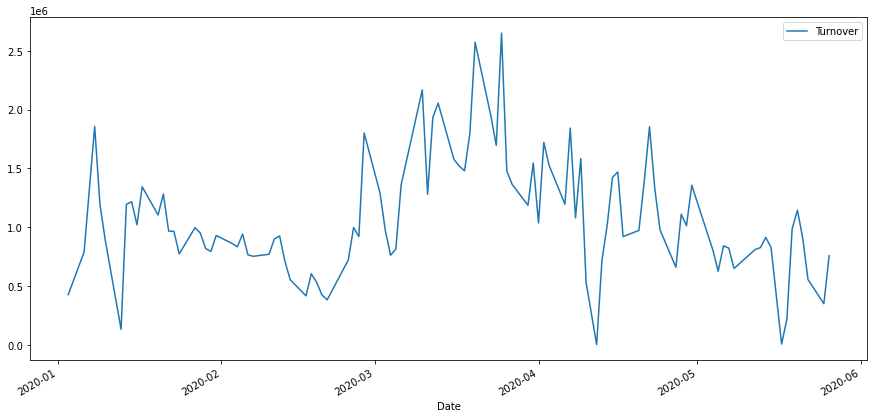

In [361]:
df=pd.read_csv(where_to_save, names=['Date','Ticker','Volume', 'Avg_price'])

plt.figure(figsize=(15,7))

df['Date']=pd.to_datetime(df['Date'])
#df=df.set_index('Date')
# WHAT ABOUT THE S PARAMETER??????
df['Turnover']=df['Volume']/df['Avg_price']

df.groupby('Date')['Turnover'].mean().plot(legend=True)



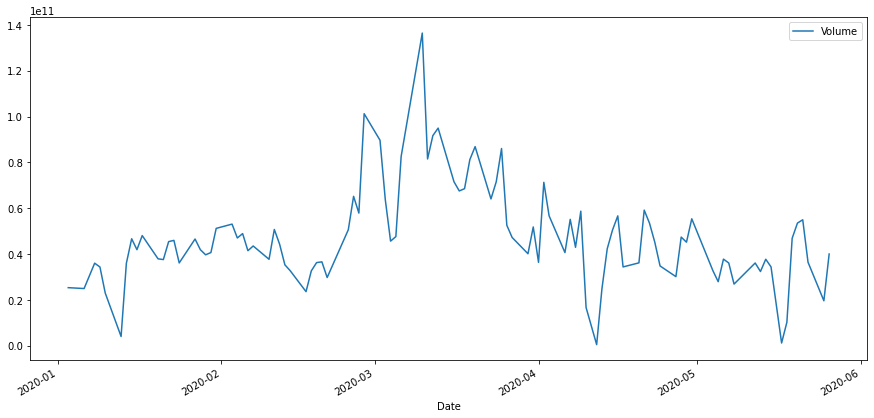

In [225]:
plt.figure(figsize=(15,7))
df.groupby('Date')['Volume'].sum().plot(legend=True)

It may be interesting to look at distinct graphs for different tickers. The following code gives a pair of graphs with volume and turnover for each ticker:

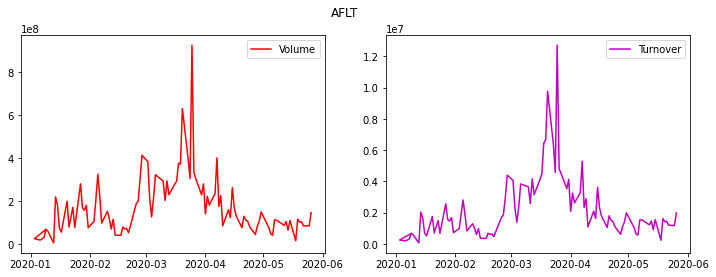

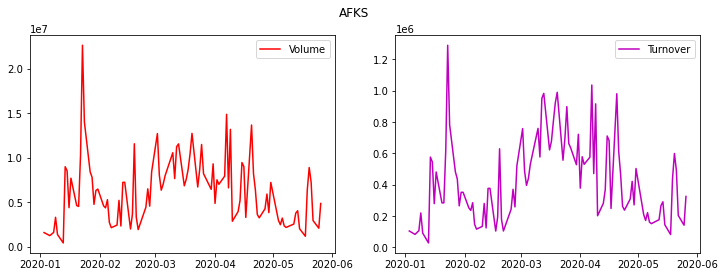

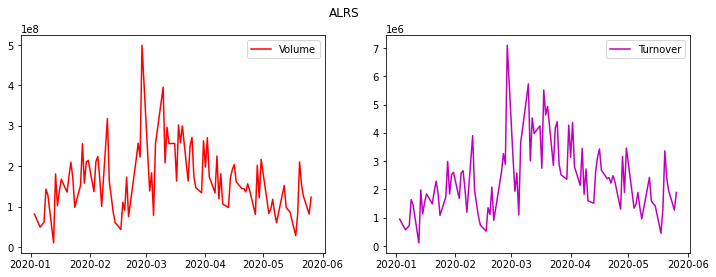

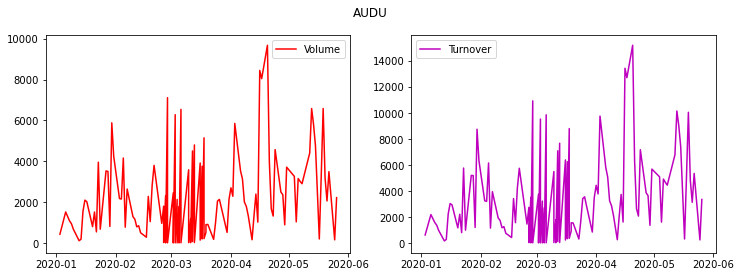

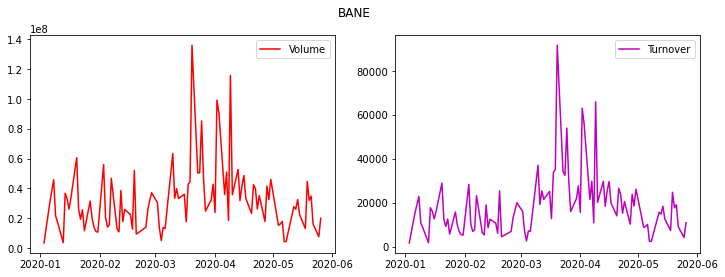

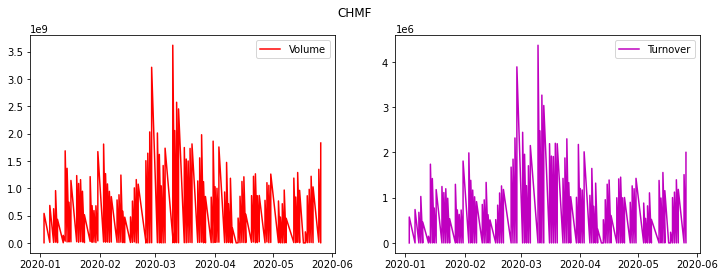

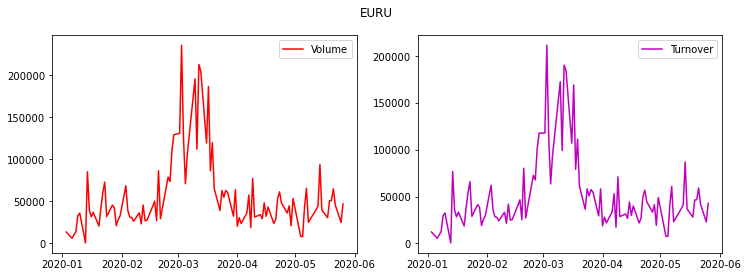

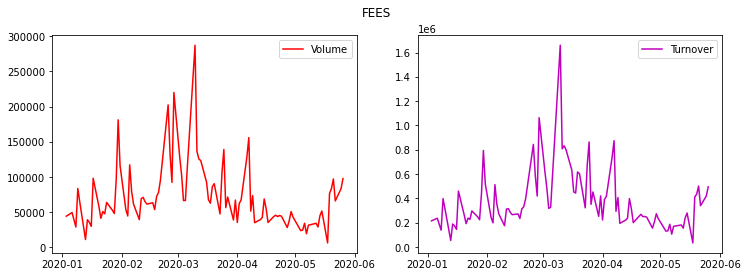

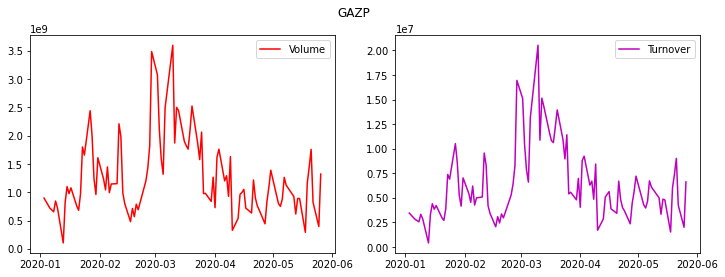

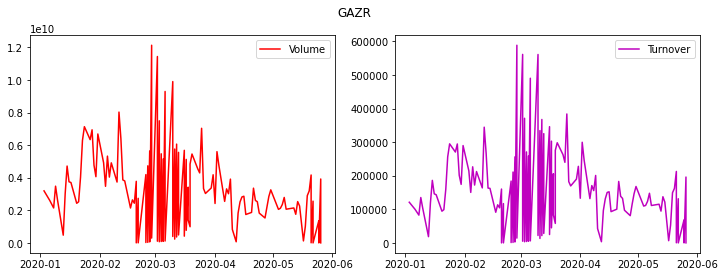

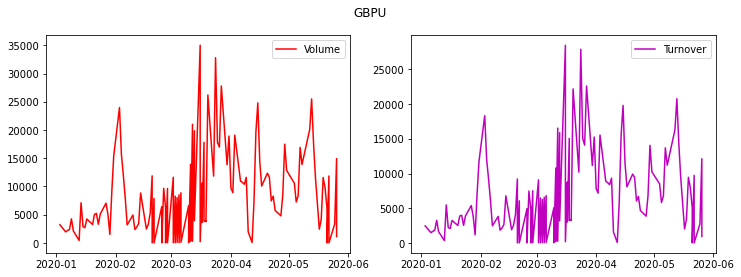

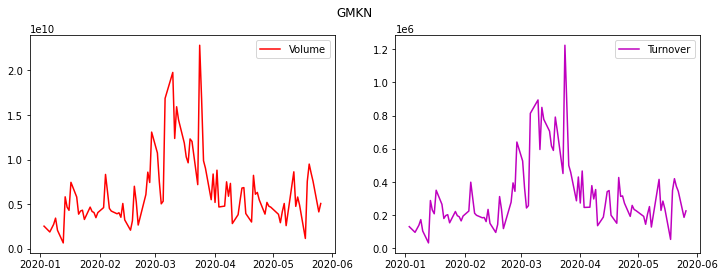

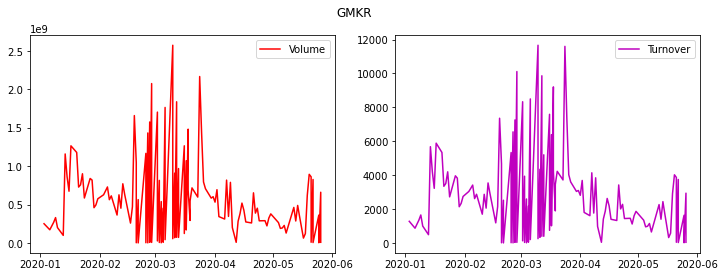

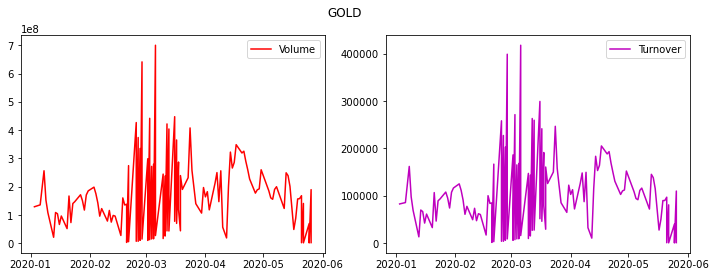

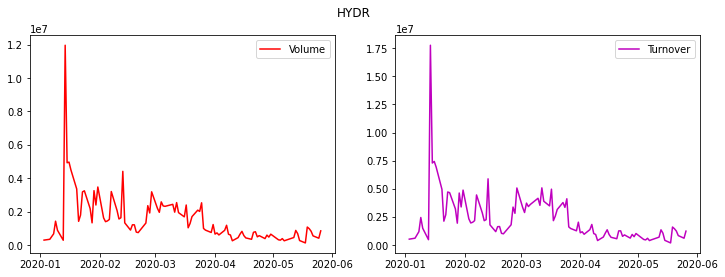

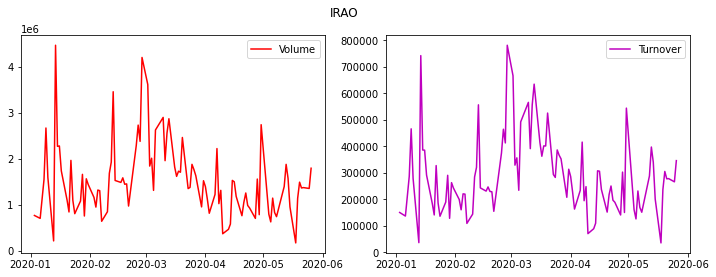

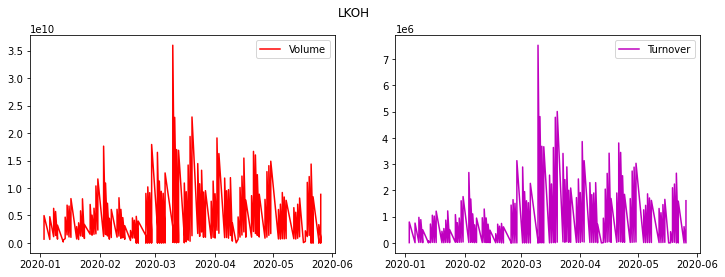

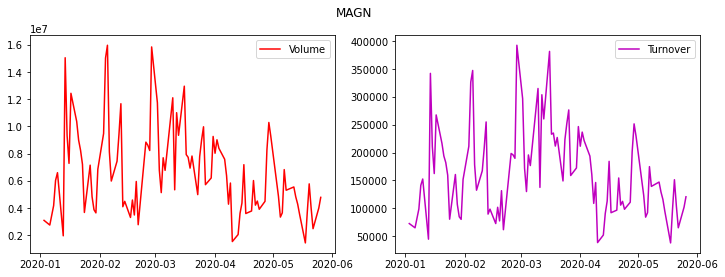

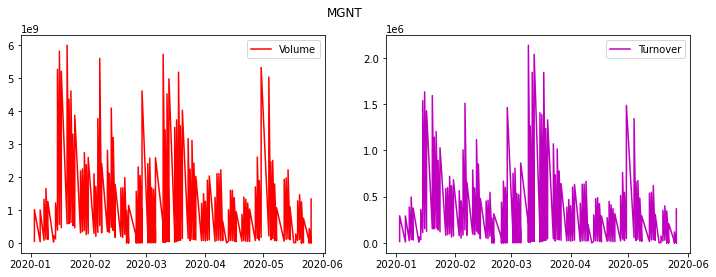

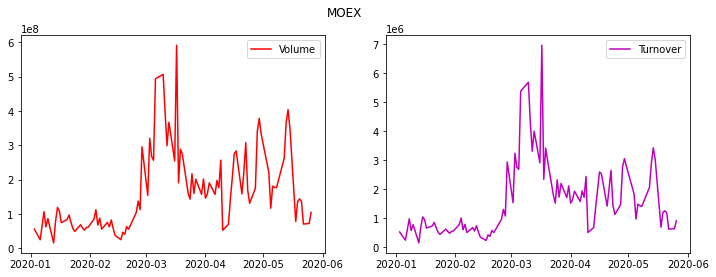

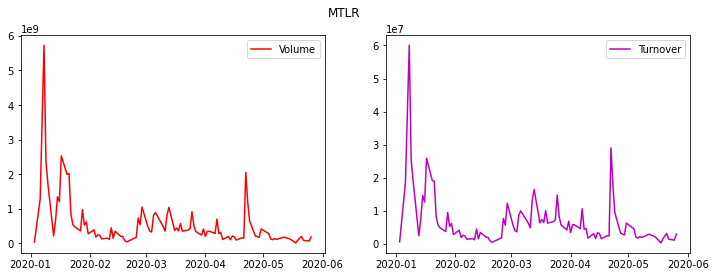

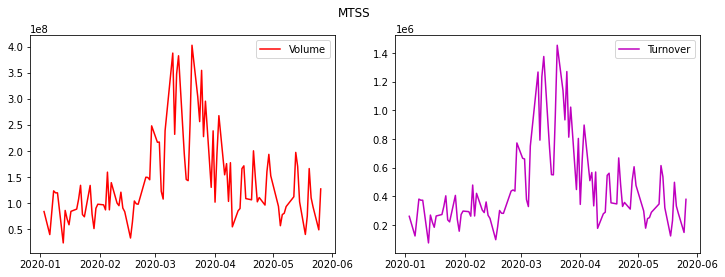

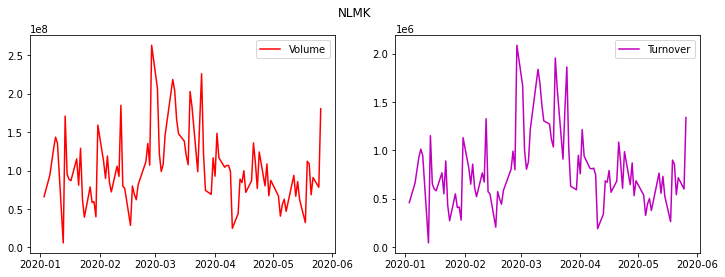

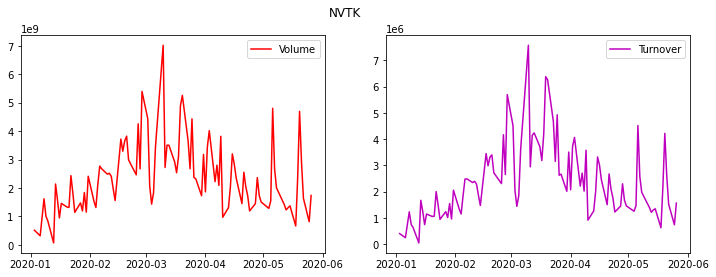

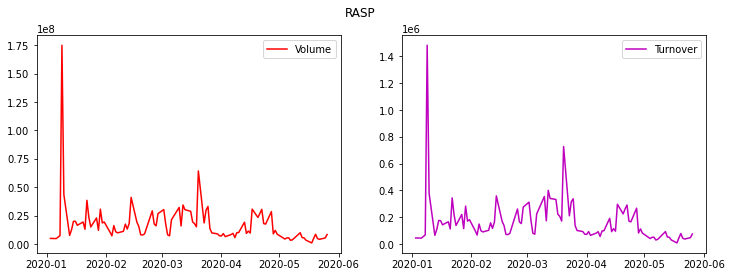

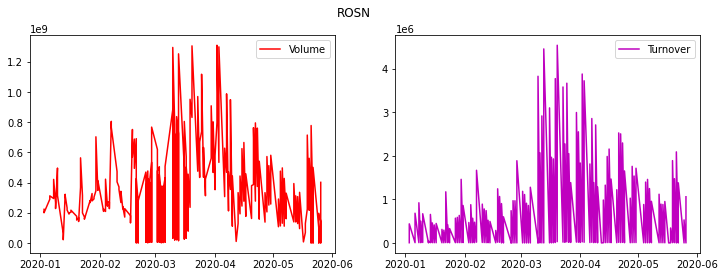

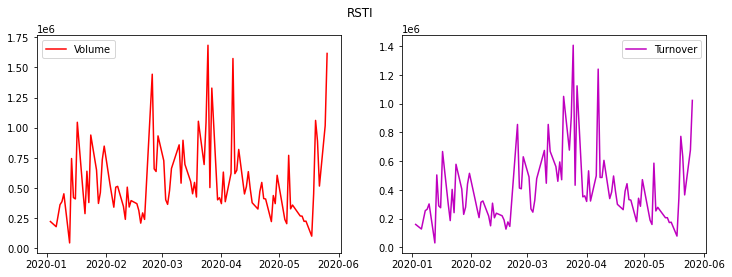

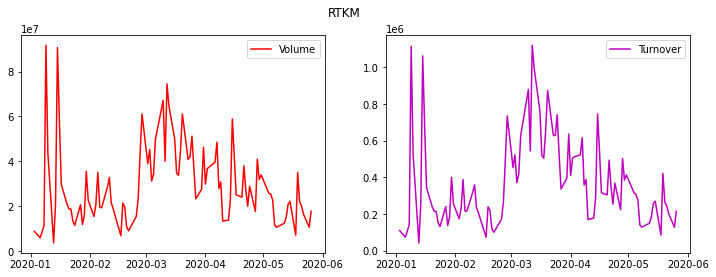

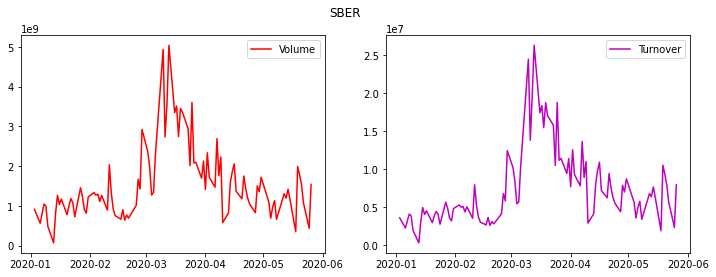

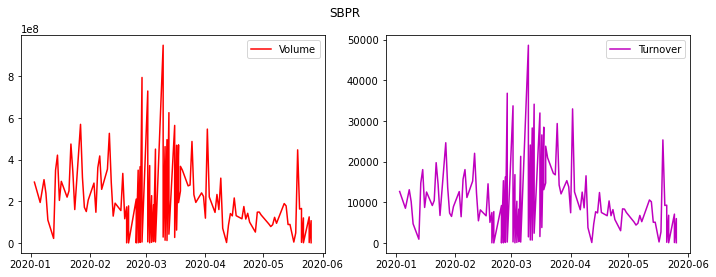

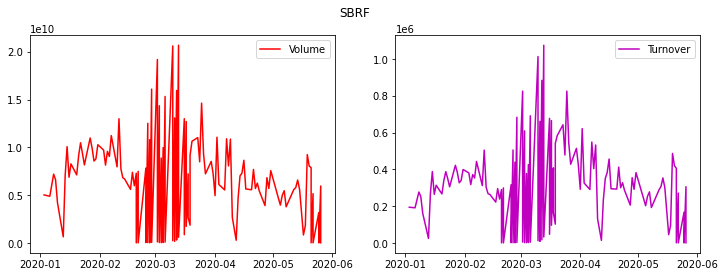

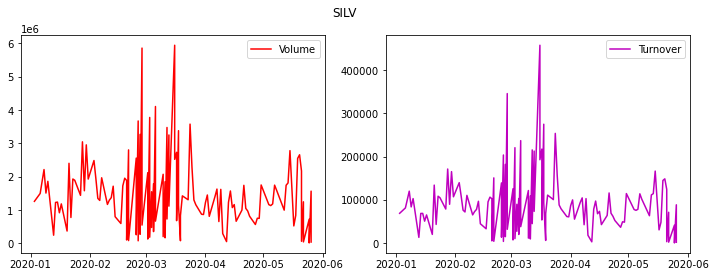

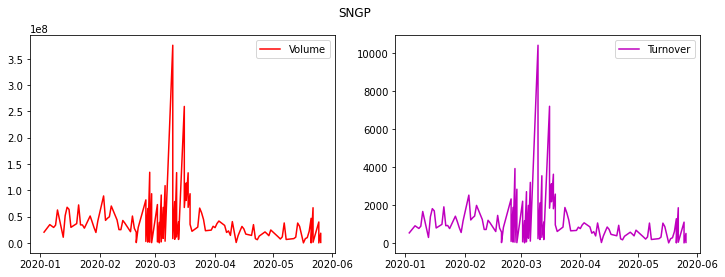

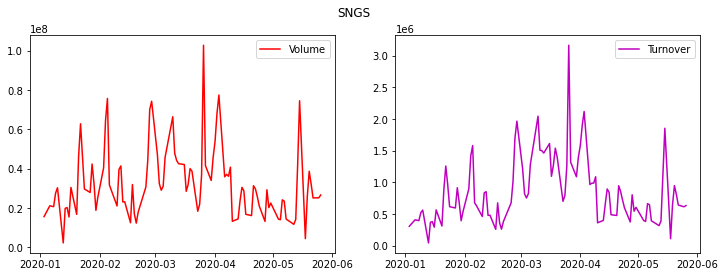

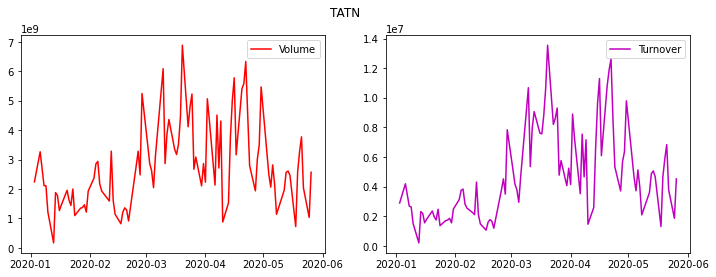

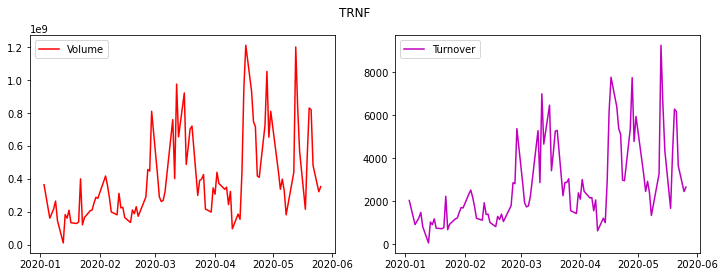

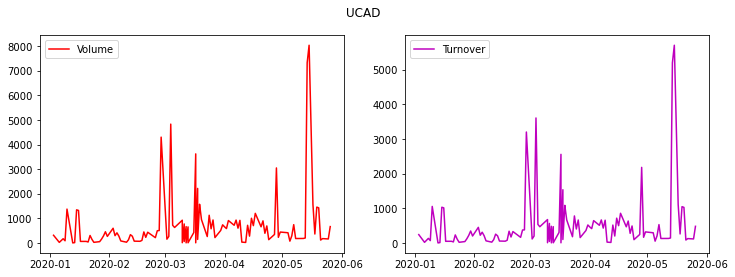

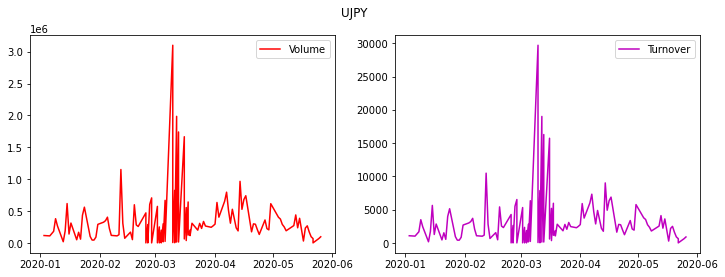

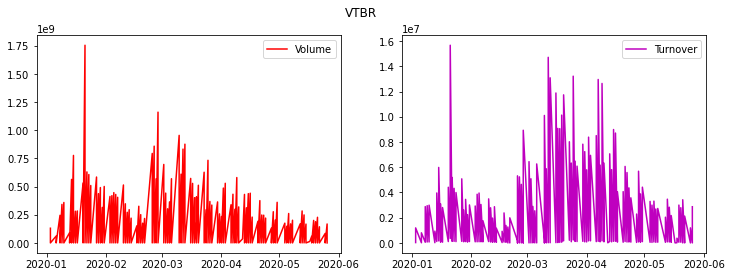

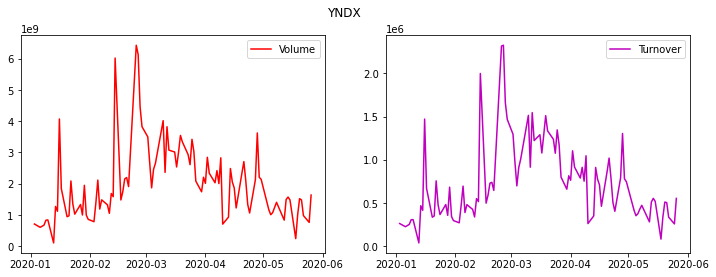

In [226]:
for name in df['Ticker'].unique():
#     plt.plot(df[df['Ticker']==name].index, df[df['Ticker']==name]['Volume'],'r')
#     plt.plot(df[df['Ticker']==name].index, df[df['Ticker']==name]['Turnover'],'m')
    
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(12,4))
    fig.suptitle(name)
    ax1.plot(df[df['Ticker']==name]['Date'], df[df['Ticker']==name]['Volume'],'r')
    ax2.plot(df[df['Ticker']==name]['Date'], df[df['Ticker']==name]['Turnover'],'m')
    
    ax1.legend(['Volume'])
    ax2.legend(['Turnover'])

    plt.show()

We can clearly see that Volume and Turnover rate do correlate very much. 

# Part 4: The Hui-Heubel Liquidity Ratio

![title](img/Hui.png)

At as usually, we need to set path to the files we work with:

In [34]:
# linux version

main_folder=r'/run/media/pchome/21F9F94B20E94FA0/My_Sites/qsh2020/txt_version'
where_to_save_prices_for_Lhh=r'/run/media/pchome/21F9F94B20E94FA0/My_Sites/qsh2020/prices_for_Lhh.csv'


In [35]:
def extract_prices(file, where_to_save):
    
    #at first, we need to calculate  min, max, and closing prices
    df=pd.read_csv(file, sep=';',header=1)
    df=df.dropna(how='any')
    max_price,min_price,closing_price=df['Price'].max(),df['Price'].min(),df.iloc[-1]['Price']


#     # get name of stock and date: windows version
    
#     filename=file.split('\\')[-1]
#     name=filename[0:4]
#     date=re.findall(r'\d\d\d\d-\d\d-\d\d',filename)[0]

    #get name of stock and date: linux version
    
    filename=file.split('/')[-1]
    name=filename[0:4]
    date=re.findall(r'\d\d\d\d-\d\d-\d\d',filename)[0]
    
    # write down data to a new file
    
    result=pd.DataFrame(np.array([[date, name, max_price, min_price, closing_price]])
                        ,columns=['Date','Ticker','Max_price', 'Min_price', 'Closing_price'])
    
    # this part appends result to the given file:
    result.to_csv(where_to_save, mode='a',header=False,index=False)

    

for folder in os.listdir(main_folder):
#     print(folder+'!!!')
#     print(os.path.join(main_folder,folder))
    source=os.path.join(main_folder,folder)
    for filename in os.listdir(source):
        #filename=file.split('\\')[-1]
        if 'Deals' in filename:
            file=os.path.join(source, filename)
            extract_prices(file, where_to_save_prices_for_Lhh)

In [228]:
prices_df=pd.read_csv(where_to_save_prices_for_Lhh, names=['Date','Ticker','Max_price', 'Min_price', 'Closing_price'])
prices_df['Date']=pd.to_datetime(prices_df['Date'])

prices_df.dropna(how='any', inplace=True)
prices_df.drop_duplicates(inplace=True)

# plt.figure(figsize=(15,7))


# # WHAT ABOUT THE S PARAMETER??????
# df['Turnover']=df['Volume']/df['Avg_price']

# df.groupby('Date')['Turnover'].mean().plot(legend=True)



Let us do a little exploratory part. In detail, the following code makes plots with prices for different tickers:

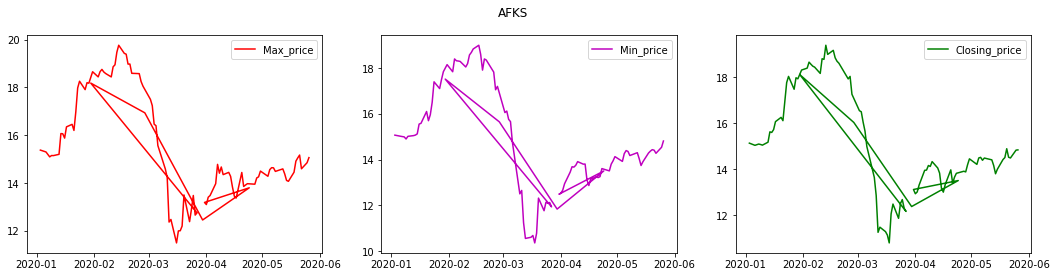

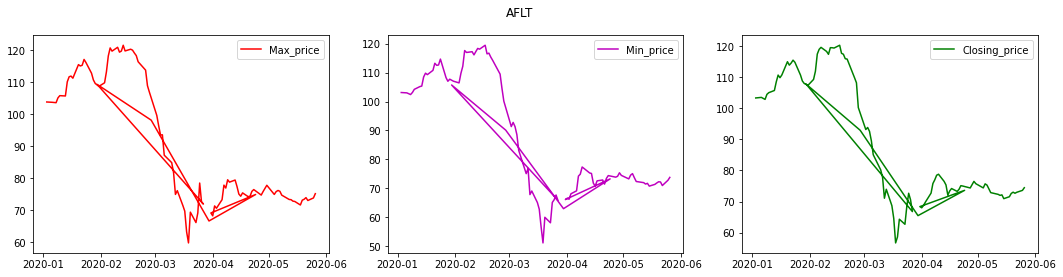

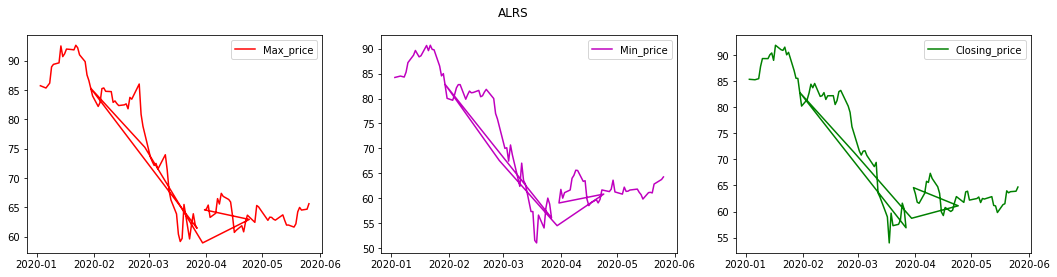

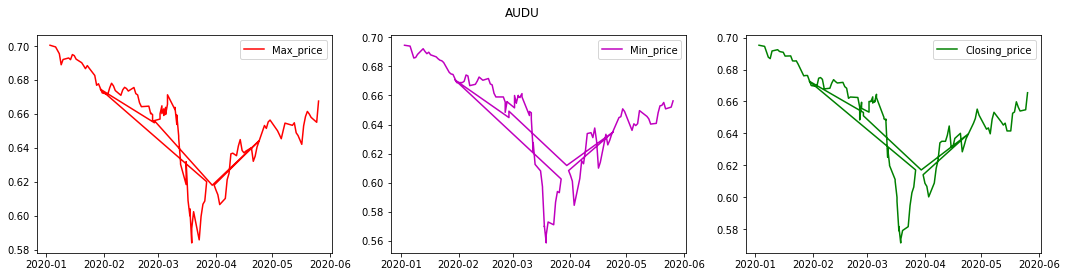

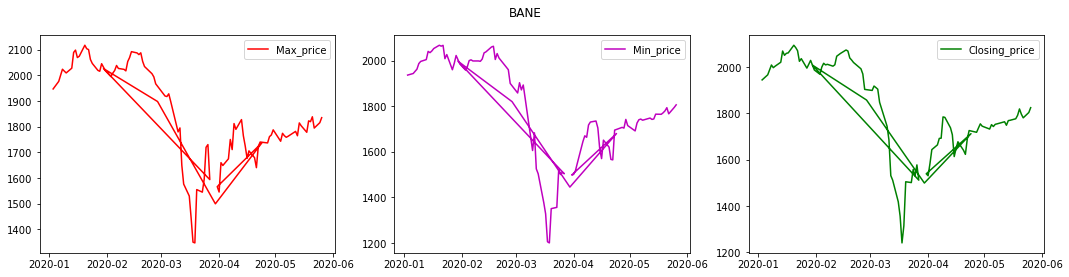

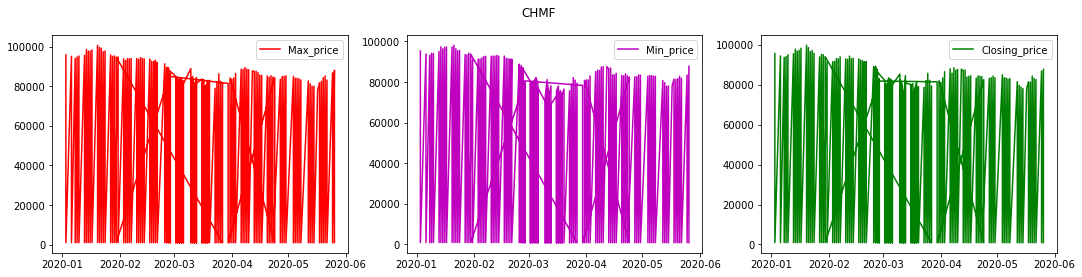

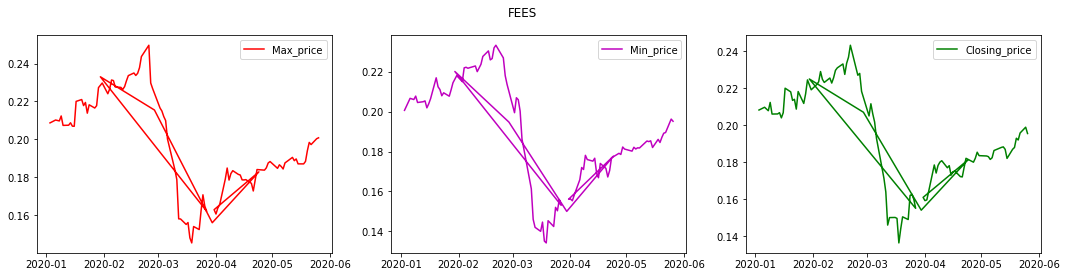

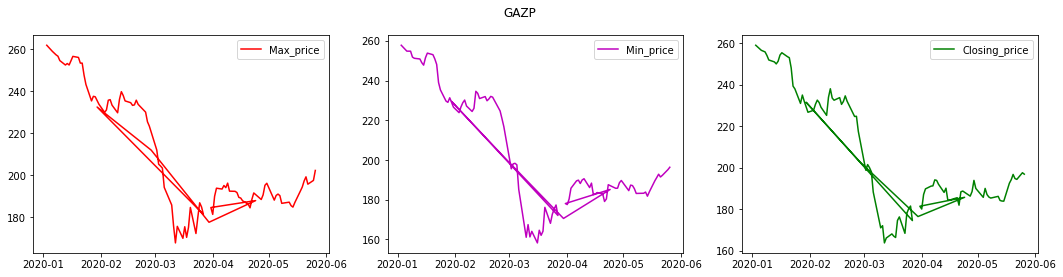

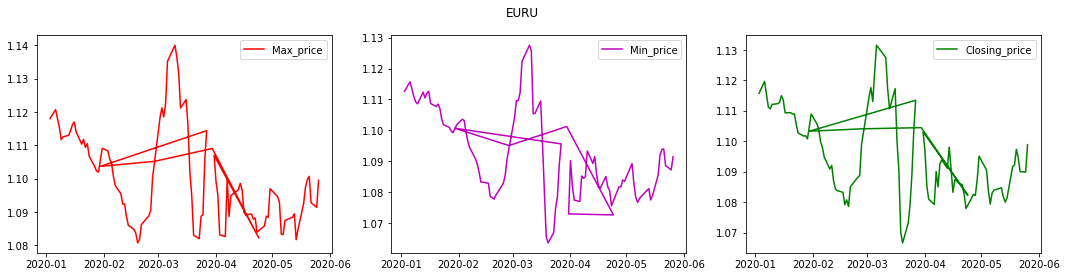

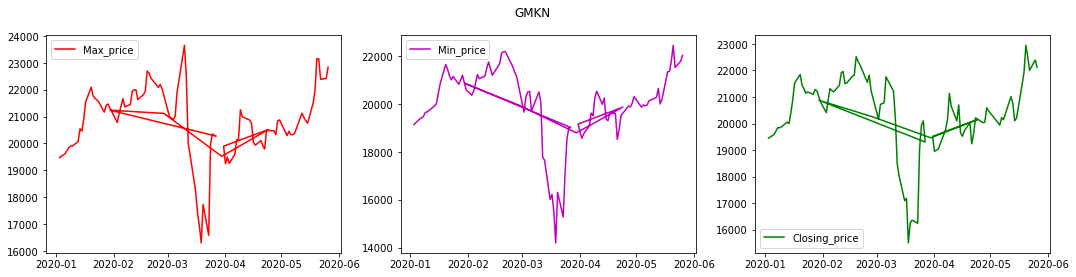

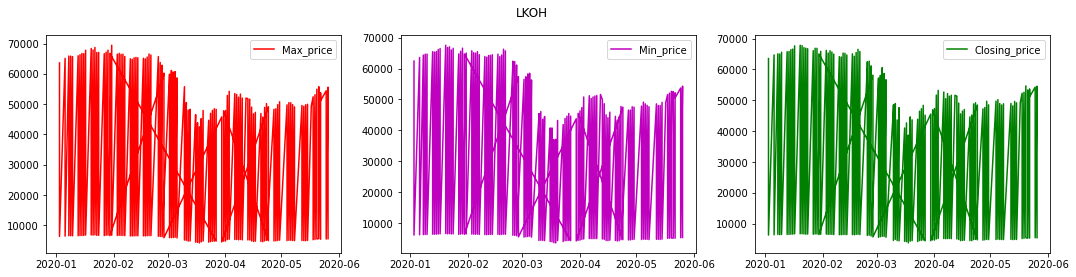

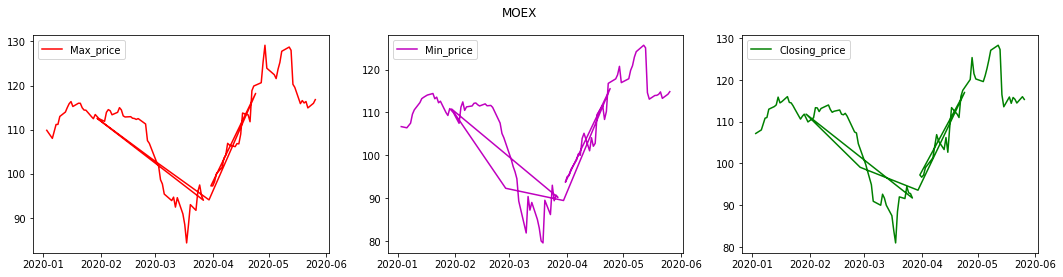

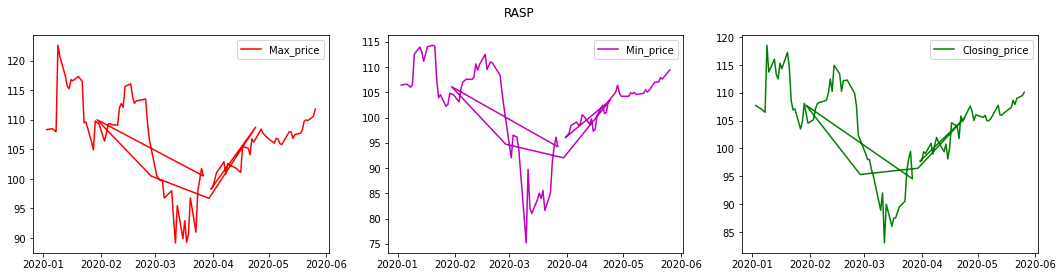

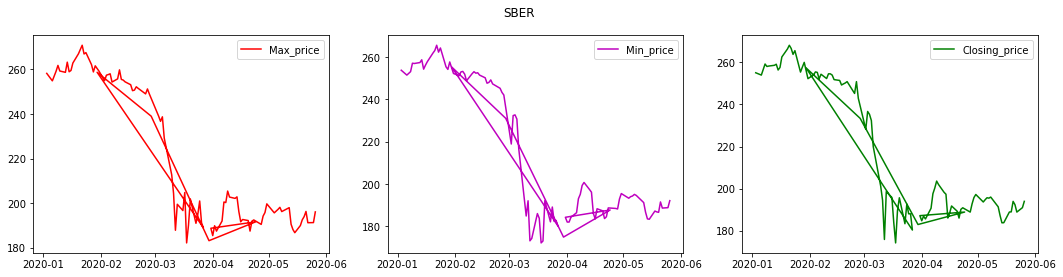

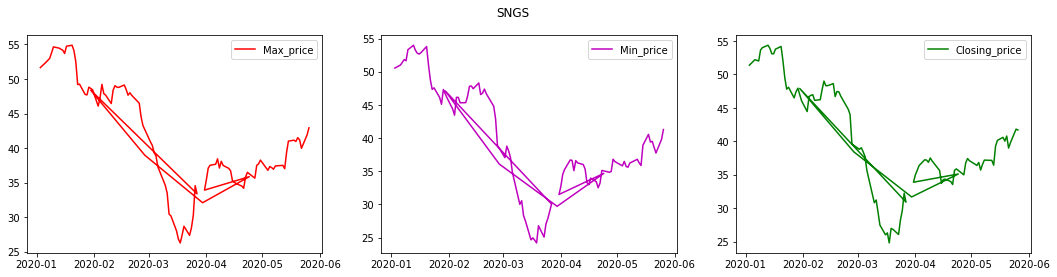

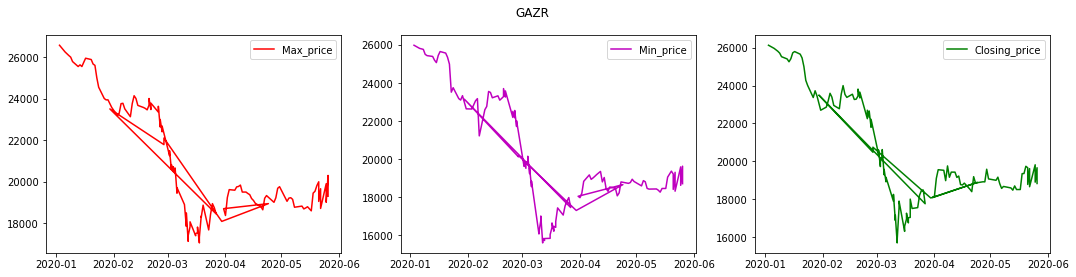

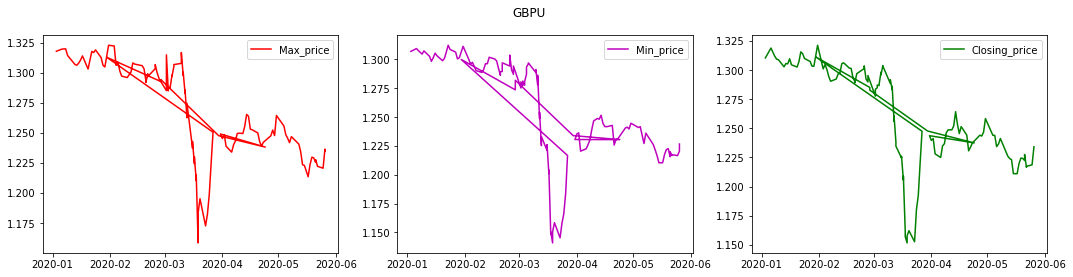

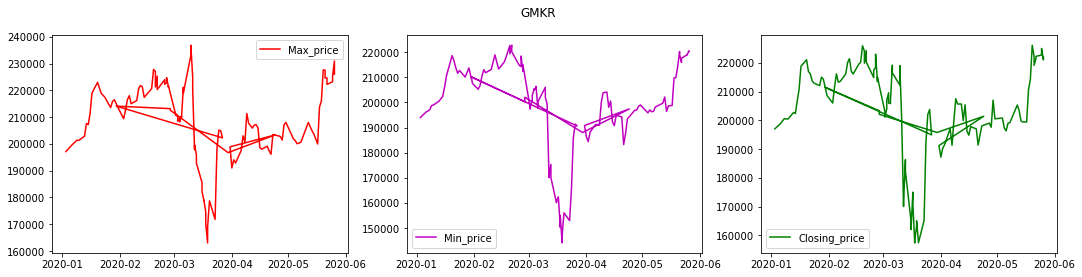

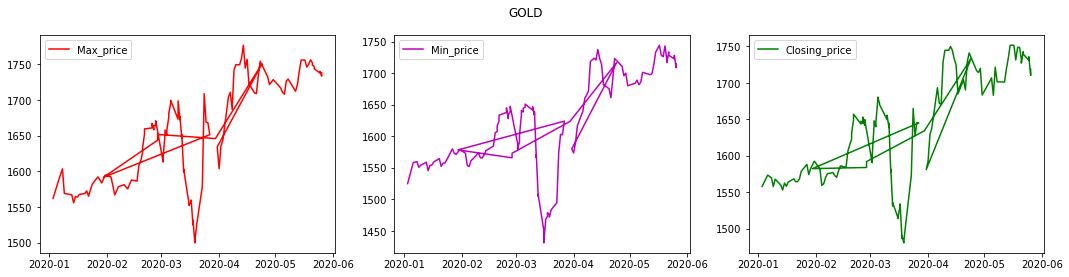

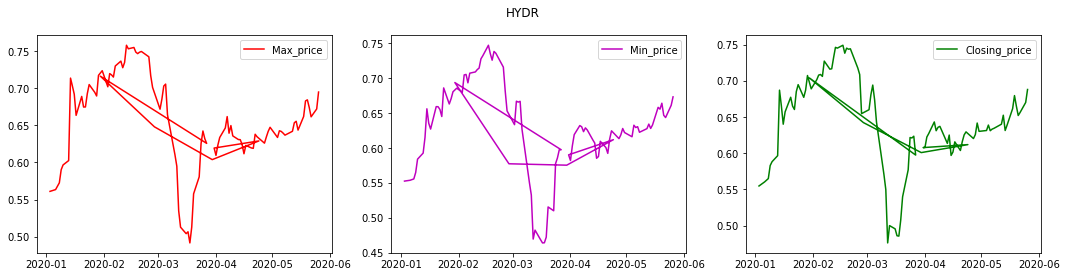

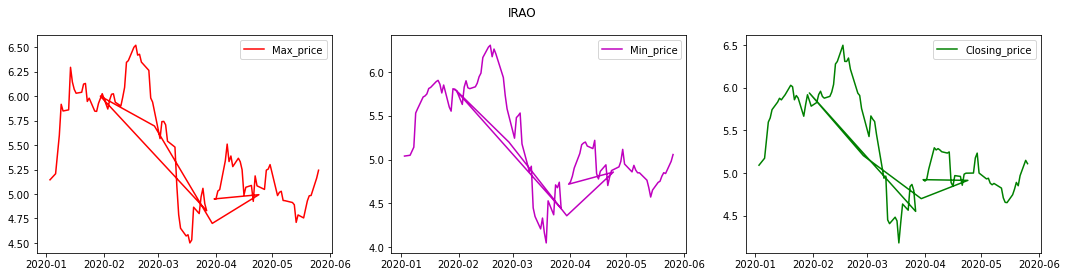

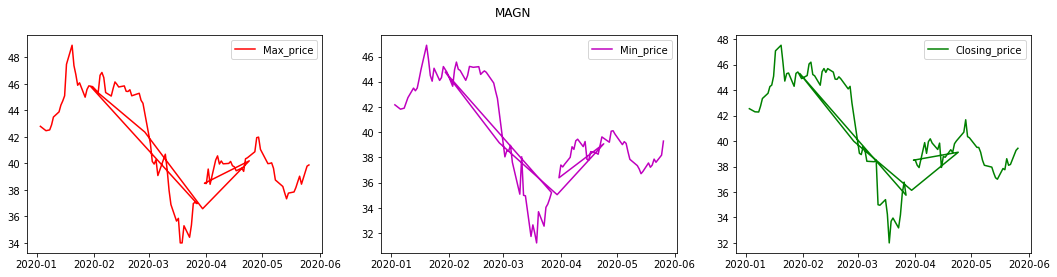

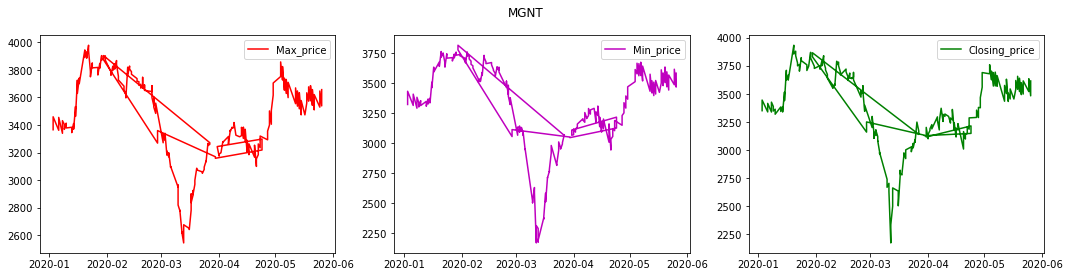

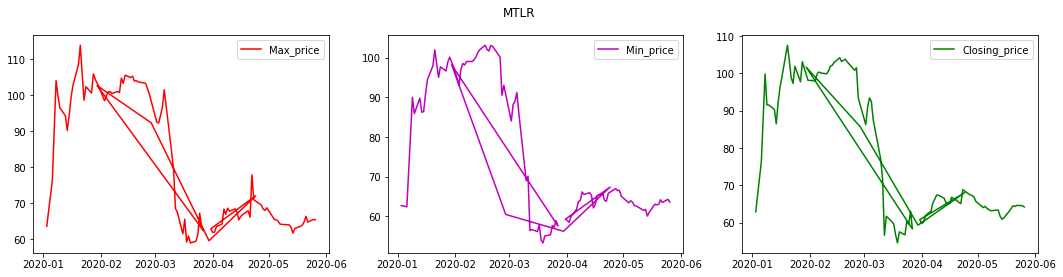

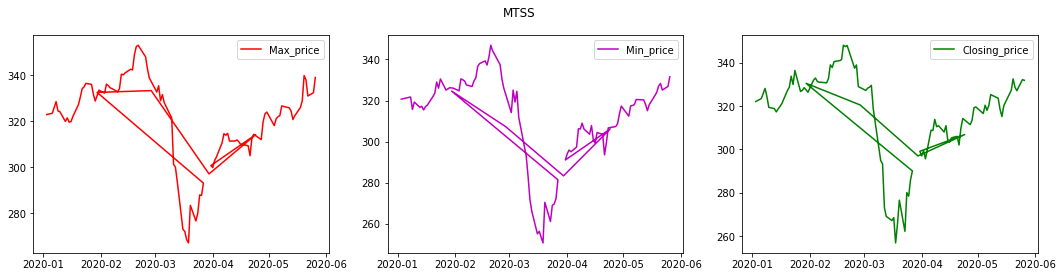

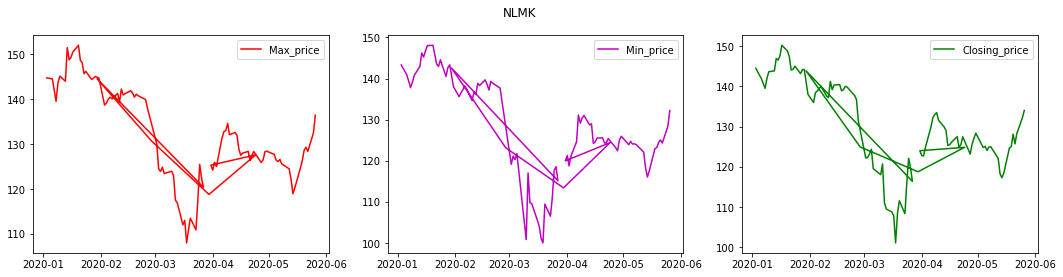

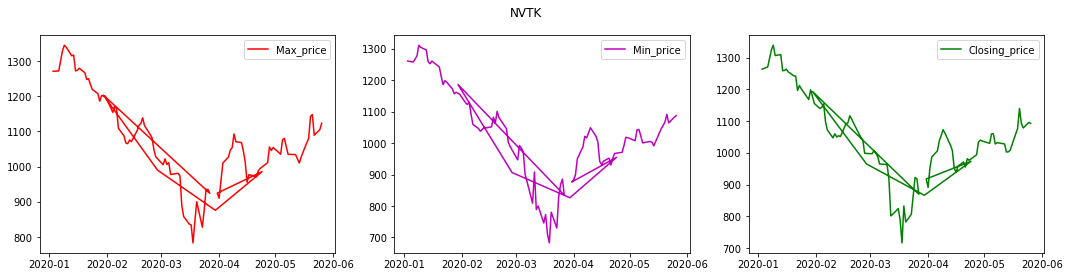

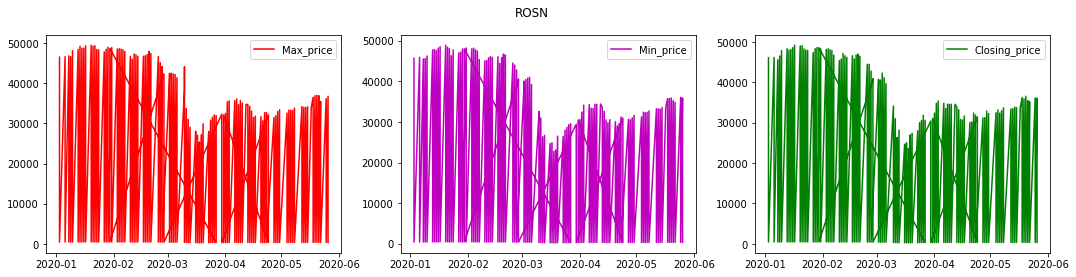

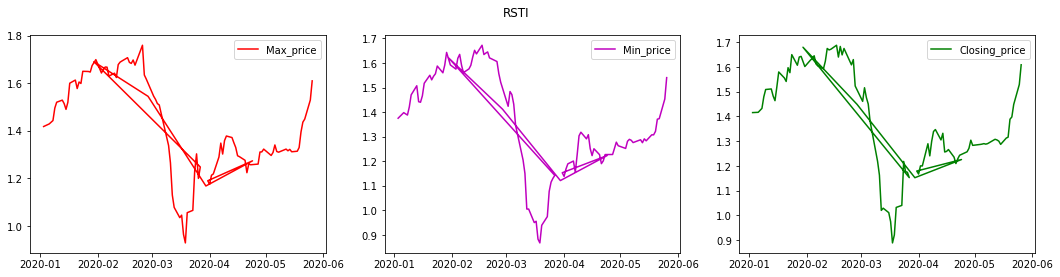

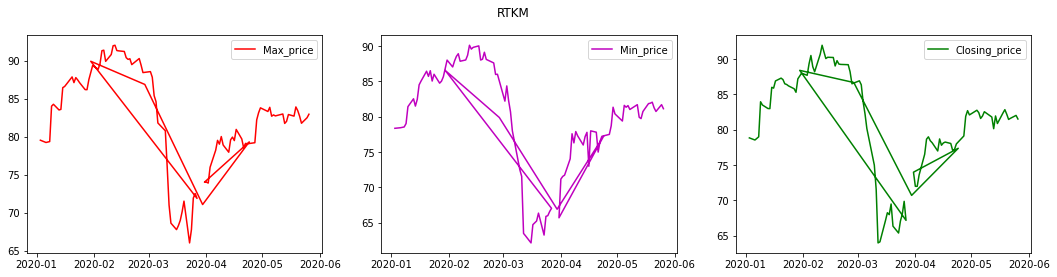

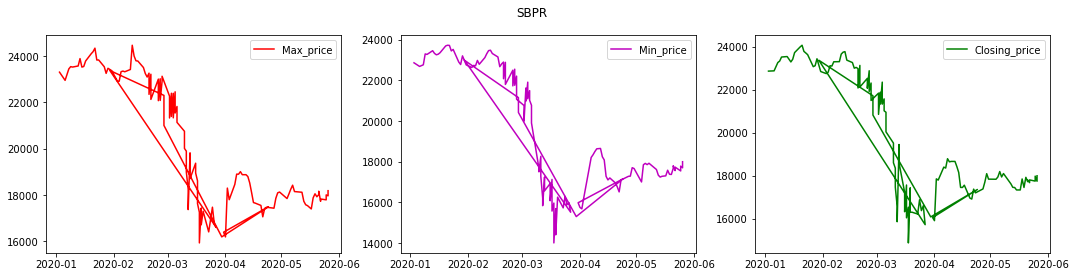

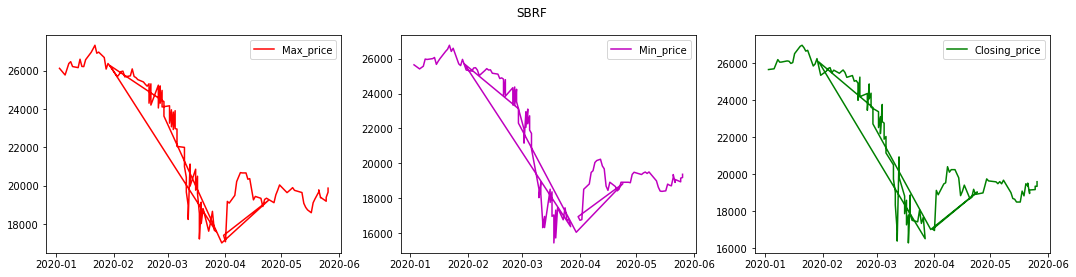

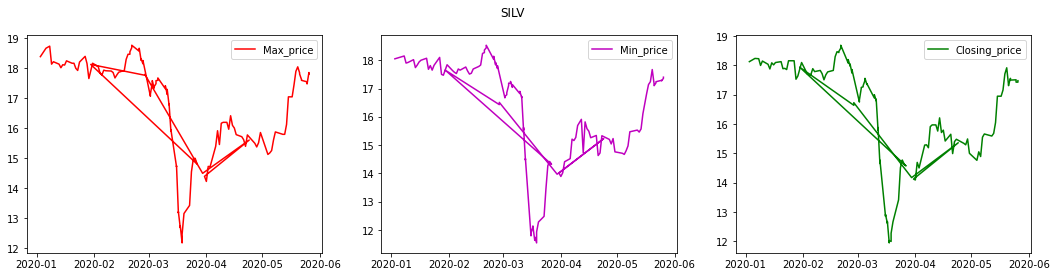

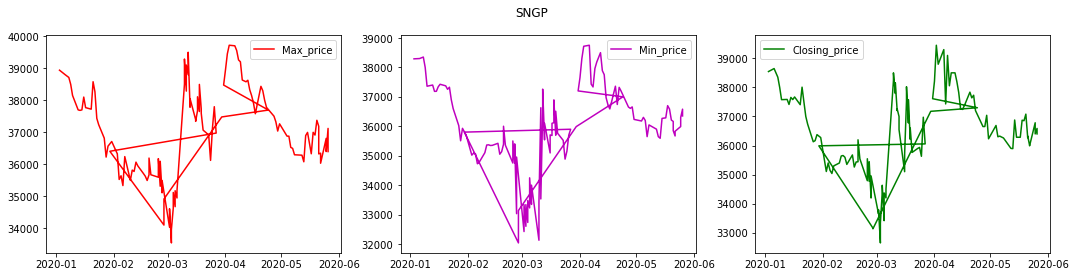

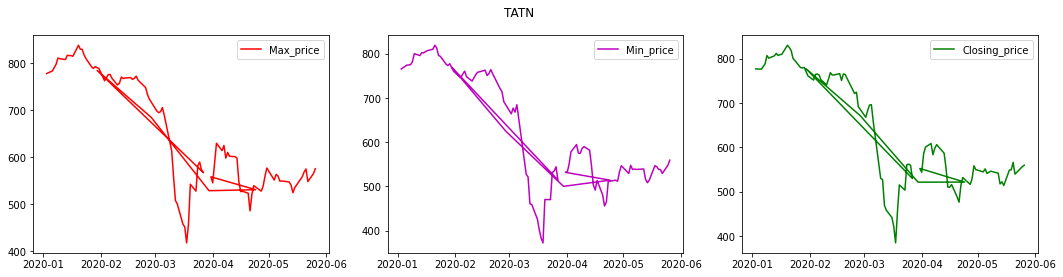

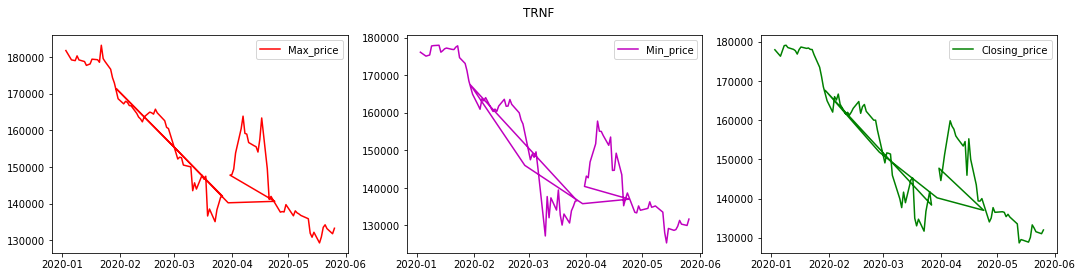

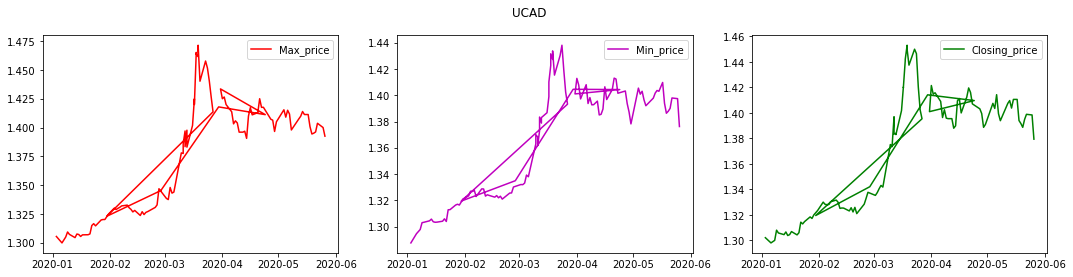

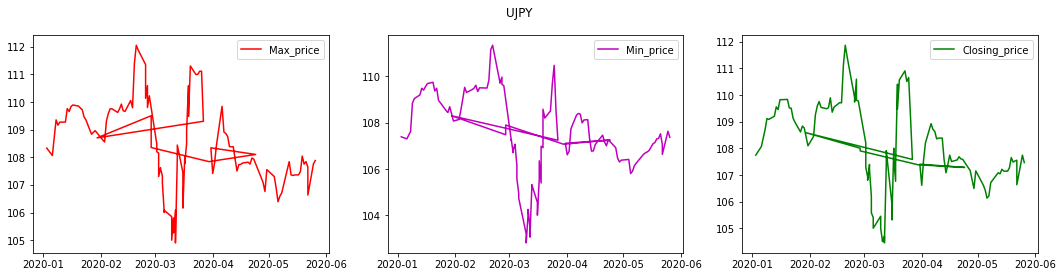

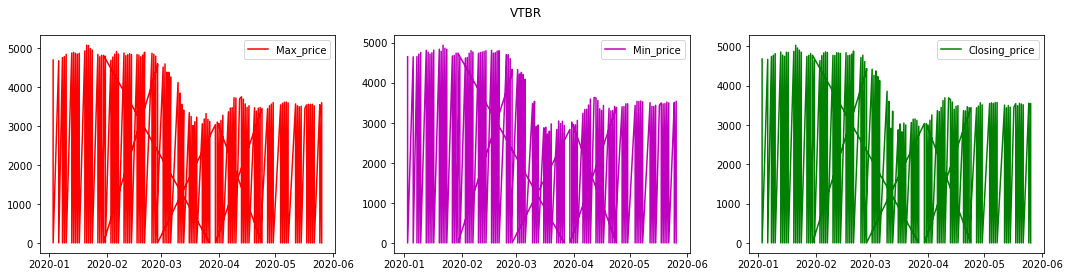

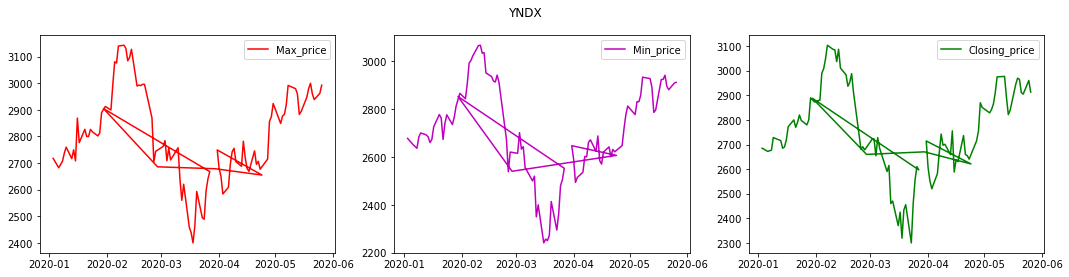

In [229]:
for name in prices_df['Ticker'].unique():
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(18,4))
    fig.suptitle(name)
    ax1.plot(prices_df[prices_df['Ticker']==name]['Date'], prices_df[prices_df['Ticker']==name]['Max_price'],'r')
    ax2.plot(prices_df[prices_df['Ticker']==name]['Date'], prices_df[prices_df['Ticker']==name]['Min_price'],'m')
    ax3.plot(prices_df[prices_df['Ticker']==name]['Date'], prices_df[prices_df['Ticker']==name]['Closing_price'],'g')
    ax1.legend(['Max_price'])
    ax2.legend(['Min_price'])
    ax3.legend(['Closing_price'])
    plt.show()

We can clearly see some peculiarities in the data: graphs explode in the beginning of April, different stocks' prices are defined over different periods of time, and there are many files with '3-20FT' in their names. I have no idea what does this all mean, however, I may not have to understand this. Probably, this is an unknown Matplotlib bug, so it makes sense to ignore this behaviour.


(details on the bug behaviour:)

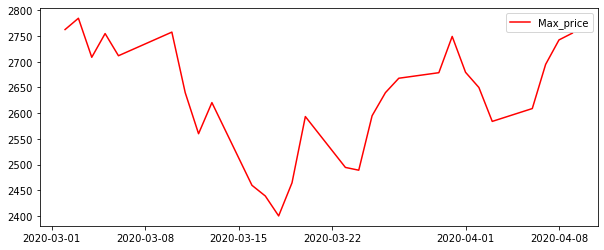

In [230]:
# # Matplotlib behaves normally in this date span
# buggy_df=prices_df[(prices_df['Date']>pd.Timestamp(2020, 3, 1))&(prices_df['Date']<pd.Timestamp(2020, 4, 10))]

# #the bug appears in this date span: 25.02.2020-30.04.2020
# # buggy_df=prices_df[(prices_df['Date']>pd.Timestamp(2020, 2, 25))&(prices_df['Date']<pd.Timestamp(2020, 4, 30))]

# name='YNDX'

# plt.figure(figsize=(10,4))
# fig.suptitle(name)
# plt.plot(buggy_df[buggy_df['Ticker']==name]['Date'], buggy_df[buggy_df['Ticker']==name]['Max_price'],'r')
# plt.legend(['Max_price'])
# plt.show()

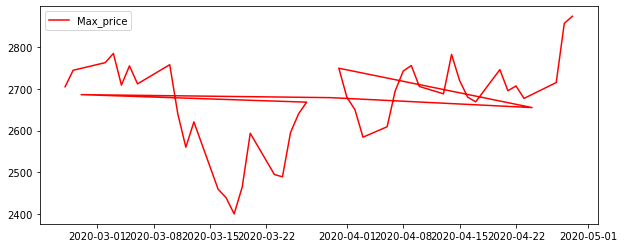

In [231]:
# # # Matplotlib behaves normally in this date span
# # buggy_df=prices_df[(prices_df['Date']>pd.Timestamp(2020, 3, 1))&(prices_df['Date']<pd.Timestamp(2020, 4, 10))]

# #the bug appears in this date span: 25.02.2020-30.04.2020
# buggy_df=prices_df[(prices_df['Date']>pd.Timestamp(2020, 2, 25))&(prices_df['Date']<pd.Timestamp(2020, 4, 30))]

# name='YNDX'

# plt.figure(figsize=(10,4))
# fig.suptitle(name)
# plt.plot(buggy_df[buggy_df['Ticker']==name]['Date'], buggy_df[buggy_df['Ticker']==name]['Max_price'],'r')
# plt.legend(['Max_price'])
# plt.show()


Time to make some rolling functions in order to calculate minimal and maximal prices over 5 days!

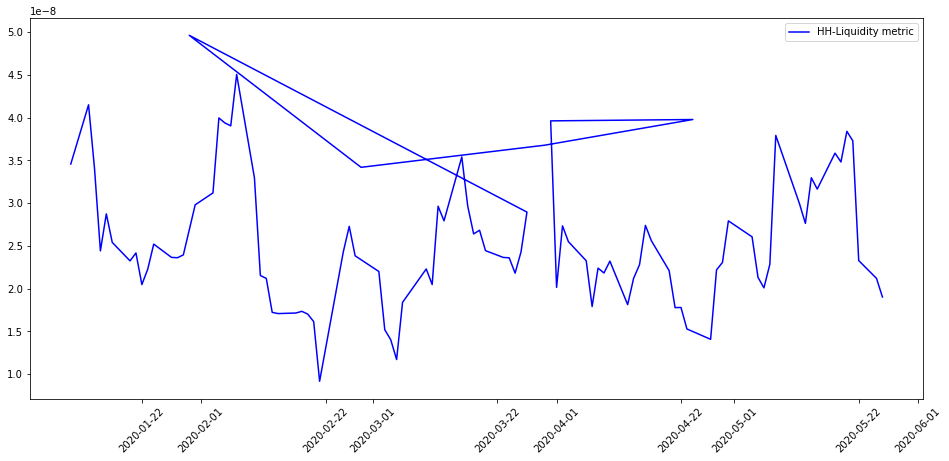

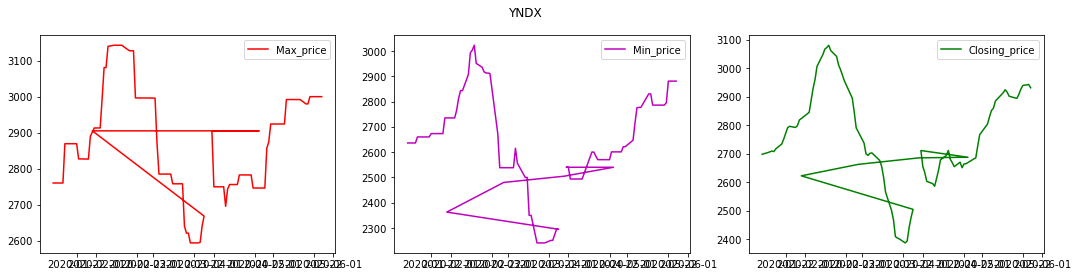

In [308]:
# At first, let us plot Hui-Heubel liquidity for YNDX stock data over 2020
name='YNDX'

dataframe=prices_df[prices_df['Ticker']==name]
# dataframe.head(10)
date = dataframe['Date']
rolling_max = dataframe['Max_price'].rolling(5).max()
rolling_min = dataframe['Min_price'].rolling(5).min()
rolling_avg_closing_price = dataframe['Closing_price'].rolling(5).mean()

new_df = pd.DataFrame({'Date':date,
                       'RMaxP':rolling_max,
                       'RMinP':rolling_min,
                       'RMeanClP':rolling_avg_closing_price}
                     ).set_index('Date')


#This part adds the row with trade volumes into the dataset
dataframe=dataframe.set_index('Date')
dataframe['Volume']=df[df['Ticker']==name].set_index('Date')['Volume']
rolling_sum_volume=dataframe['Volume'].rolling(5).sum()
new_df['Volume']=rolling_sum_volume


# new_df['Lhh']=(rolling_max-rolling_min)*rolling_avg_closing_price/(rolling_min*rolling_sum_volume)
new_df['Lhh']=(new_df['RMaxP']-new_df['RMinP'])*new_df['RMeanClP']/(new_df['RMinP']*new_df['Volume'])

# plt.plot(date, rolling_max, 'r')
# plt.plot(date, rolling_min, 'm')
# plt.plot(date, rolling_avg, 'g')
plt.figure(figsize=(16,7))
plt.plot(new_df.index, new_df['Lhh'], 'b')
plt.legend(['HH-Liquidity metric'])
plt.xticks(rotation=45)
plt.show()

new_df.head(10)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(18,4))
fig.suptitle(name)
ax1.plot(new_df.index, new_df['RMaxP'],'r')
ax2.plot(new_df.index, new_df['RMinP'],'m')
ax3.plot(new_df.index, new_df['RMeanClP'],'g')
ax1.legend(['Max_price'])
ax2.legend(['Min_price'])
ax3.legend(['Closing_price'])

now I need to wrap it into a function, in order to extract median values for the whole market


In [336]:
def make_normed_Lhh(name):
    dataframe=prices_df[prices_df['Ticker']==name]
    # dataframe.head(10)
    date = dataframe['Date']
    rolling_max = dataframe['Max_price'].rolling(5).max()
    rolling_min = dataframe['Min_price'].rolling(5).min()
    rolling_avg_closing_price = dataframe['Closing_price'].rolling(5).mean()

    new_df = pd.DataFrame({'Date':date,
                           'RMaxP':rolling_max,
                           'RMinP':rolling_min,
                           'RMeanClP':rolling_avg_closing_price}
                         ).set_index('Date')


    #This part adds the row with trade volumes into the dataset
    dataframe=dataframe.set_index('Date')
    dataframe['Volume']=df[df['Ticker']==name].set_index('Date')['Volume']
    rolling_sum_volume=dataframe['Volume'].rolling(5).sum()
    new_df['Volume']=rolling_sum_volume


    # new_df['Lhh']=(rolling_max-rolling_min)*rolling_avg_closing_price/(rolling_min*rolling_sum_volume)
    new_df['Lhh']=(new_df['RMaxP']-new_df['RMinP'])*new_df['RMeanClP']/(new_df['RMinP']*new_df['Volume'])
    new_df['normed_Lhh'] = (new_df['Lhh']*new_df['Volume'].mean()/1000)
    return new_df['normed_Lhh']


def make_Lhh(name):
    dataframe=prices_df[prices_df['Ticker']==name]
    # dataframe.head(10)
    date = dataframe['Date']
    rolling_max = dataframe['Max_price'].rolling(5).max()
    rolling_min = dataframe['Min_price'].rolling(5).min()
    rolling_avg_closing_price = dataframe['Closing_price'].rolling(5).mean()

    new_df = pd.DataFrame({'Date':date,
                           'RMaxP':rolling_max,
                           'RMinP':rolling_min,
                           'RMeanClP':rolling_avg_closing_price}
                         ).set_index('Date')


    #This part adds the row with trade volumes into the dataset
    dataframe=dataframe.set_index('Date')
    dataframe['Volume']=df[df['Ticker']==name].set_index('Date')['Volume']
    rolling_sum_volume=dataframe['Volume'].rolling(5).sum()
    new_df['Volume']=rolling_sum_volume


    # new_df['Lhh']=(rolling_max-rolling_min)*rolling_avg_closing_price/(rolling_min*rolling_sum_volume)
    new_df['Lhh']=(new_df['RMaxP']-new_df['RMinP'])*new_df['RMeanClP']/(new_df['RMinP']*new_df['Volume'])
    return new_df['Lhh']

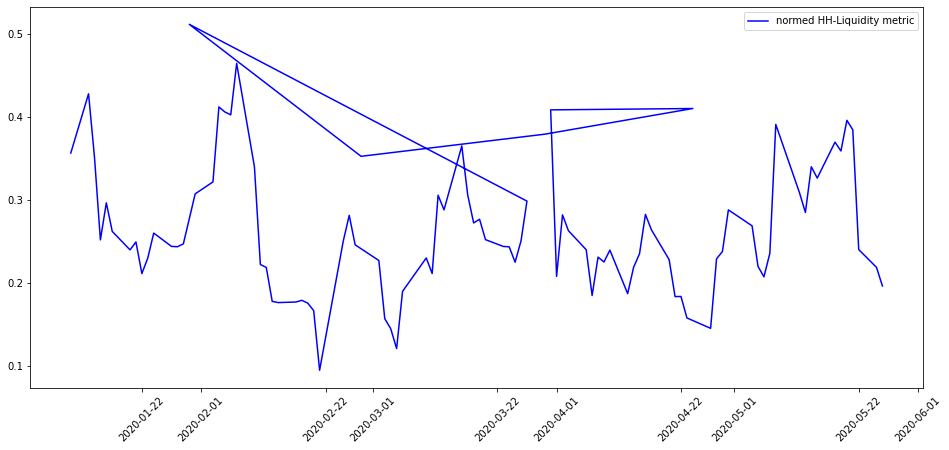

In [318]:
# new_df['normed_Lhh'] = (new_df['Lhh']*new_df['Volume'].mean()/1000)
# plt.figure(figsize=(16,7))
# plt.plot(new_df.index, new_df['normed_Lhh'], 'b')
# plt.legend(['normed HH-Liquidity metric'])
# plt.xticks(rotation=45)
# plt.show()


In [343]:
lhhs_df=pd.DataFrame()
for name in prices_df['Ticker'].unique():
    try:
        lhhs_df[name] = make_Lhh(name)
    except ValueError as err:
        print(err)


cannot reindex from a duplicate axis
cannot reindex from a duplicate axis
cannot reindex from a duplicate axis
cannot reindex from a duplicate axis
cannot reindex from a duplicate axis
cannot reindex from a duplicate axis
cannot reindex from a duplicate axis
cannot reindex from a duplicate axis
cannot reindex from a duplicate axis
cannot reindex from a duplicate axis
cannot reindex from a duplicate axis
cannot reindex from a duplicate axis
cannot reindex from a duplicate axis
cannot reindex from a duplicate axis
cannot reindex from a duplicate axis
cannot reindex from a duplicate axis
cannot reindex from a duplicate axis


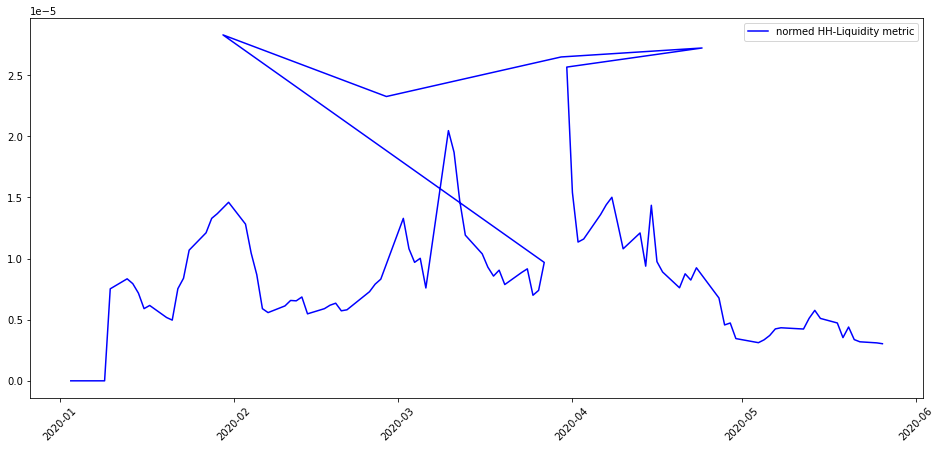

In [355]:
shit=lhhs_df.sum(axis=1)
plt.figure(figsize=(16,7))
plt.plot(shit.index, shit, 'b')
plt.legend(['normed HH-Liquidity metric'])
plt.xticks(rotation=45)
plt.show()

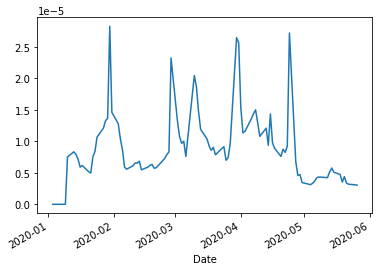

In [356]:
shit.plot()

# Part 5: my own metrics

At first,  the turnover rate and the volume of trades would probably be more useful, if I would use a 5 days-long rolling window.

(There are only 2 questions left:

1) How often there are frictionless assets (bid-ask spread equals zero) at the market

2) What can we say about skewness of the distribution of the order book depth?

)

In [ ]:
# this part is unfinished

# df.groupby('Date')['Turnover'].rolling(5).sum().plot(legend=True)

# # df.groupby('Date')['Turnover'].mean().plot(legend=True)

# Part 6: conclusions and metrics ranking

We can clearly see that the median relative bid-ask spread, turnover rate and volume of trades indicate a considerable leap in liquidity in april. However, the median relative bid-ask spread indicates the trend more clearly. The Hui-Huebel liquidity metric turned out to not indicate anything at all. Accordingly, it follows that metrics may be ranked in the following way:
1. Median relative bid-ask spread (the median is taken amongst all stocks) - works properly
2. Turnover rate and the volume of trades - indicate a trend and look useful
3. Hui-Huebel metric seems to be useless at all. In addition, it triggers matplotlib bugs.

Median relative bid-ask spread:

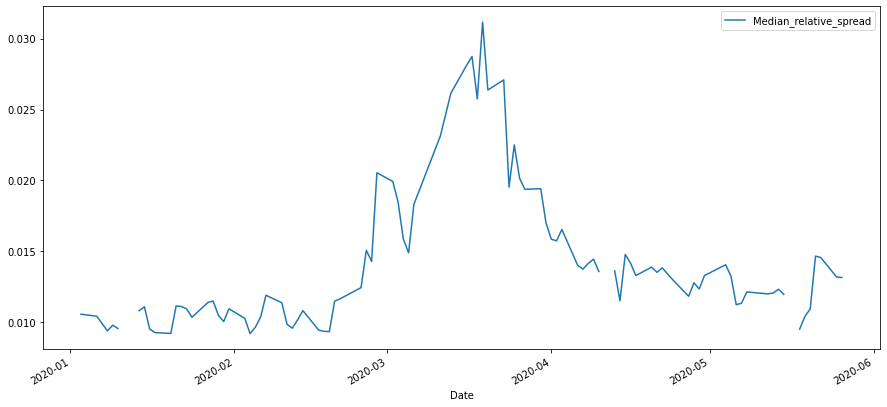

In [363]:
df=pd.read_csv(where_to_append_result, names=['Date','Ticker','Median_relative_spread'])
df['Date']=pd.to_datetime(df['Date'])
df=df.set_index('Date')

plt.figure(figsize=(15,7))
df.groupby('Date')['Median_relative_spread'].median().plot(legend='Relative spread median amongst all stocks')

Median turnover rate

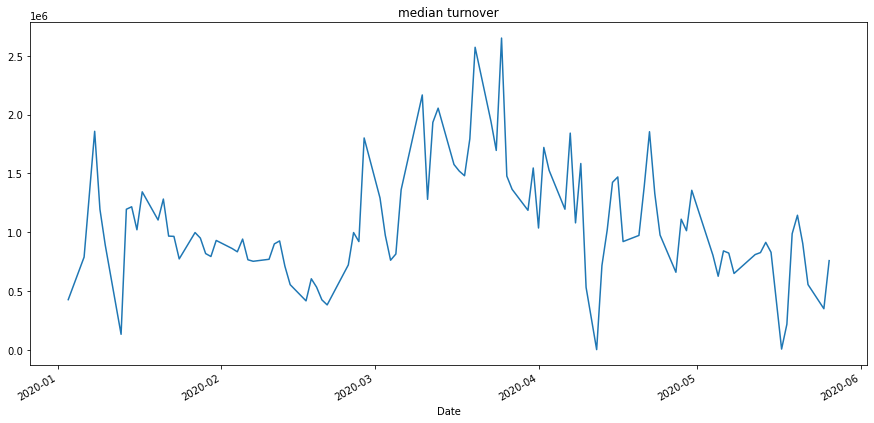

In [367]:
df=pd.read_csv(where_to_save, names=['Date','Ticker','Volume', 'Avg_price'])
plt.figure(figsize=(15,7))
df['Date']=pd.to_datetime(df['Date'])
df['Turnover']=df['Volume']/df['Avg_price']
df.groupby('Date')['Turnover'].mean().plot(title='median turnover')

Total volume of day trades:

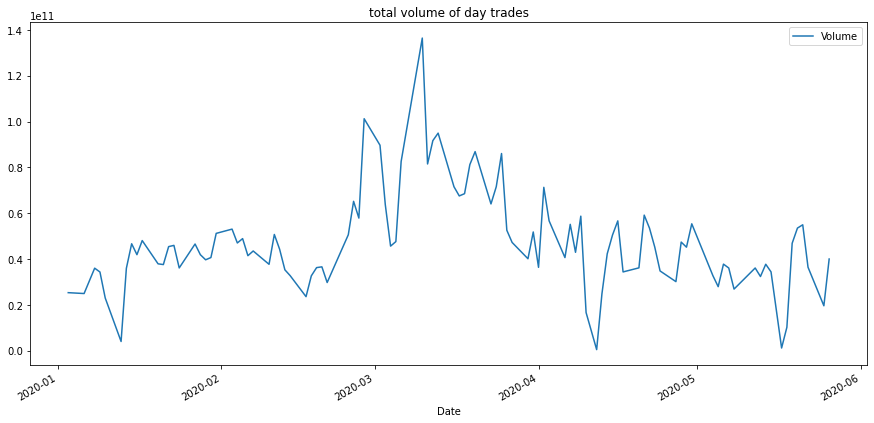

In [369]:
plt.figure(figsize=(15,7))
df.groupby('Date')['Volume'].sum().plot(legend=True,title='total volume of day trades')
